### Table of Contents

* [Creating Patient Group With Metabolomics Data](#Creating_patient_group)
* [Statistical Testing For Age, Ethnicity, and Sex For Progressors and Non-progressors](#Progressors)
* [Statistical Testing For Age, Ethnicity, Sex, and Patient Sizes For Pre-diabetic Groups](#Groups)

<a class="anchor" id="Creating_patient_group"></a>

First we import the packages we may need for the notebook.

In [1]:
import numpy as np
from numpy import linalg
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import dask.dataframe as dd
import time
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
import shap
import time
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from numpy import mean
from numpy import std
import seaborn as sns
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import chi2

Below we import the patients we incorrectly labeled as prediabetics who are actually diabetics at the start of the study.

In [12]:
actual_diabetics = pd.read_csv('diabetics_at_start_of_study.csv')
actual_diabetics

,Unnamed: 0,eid
0,715,2425377
1,2751,5512282
2,3050,5724786
3,10977,4256846
4,12039,2189918
...,...,...
185,488158,1665367
186,489973,2739978
187,490542,5684156
188,494158,5209790


Next we import the dataframe with the progression outcomes.

In [3]:
prediabetes_with_targets = pd.read_csv('final_cohort_of_prediabetics.csv')
prediabetes_with_targets = prediabetes_with_targets.drop(columns = 'Unnamed: 0')
prediabetes_with_targets

,eid,target
0,1000330,0
1,1000789,0
2,1005310,0
3,1006688,0
4,1006718,0
...,...,...
9749,2799525,1
9750,2733348,1
9751,1683777,1
9752,5857129,1


Below we import the dataframe that has many features from the UKBiobank. We drop the first column which is just an identity column brought over from our previous analysis.

In [4]:
prediabetes_with_features = pd.read_csv('all_features_prediabetics_only_9754_patients.csv')
prediabetes_with_features = prediabetes_with_features.drop(columns = ['Unnamed: 0'])
prediabetes_with_features

Columns (42,43,213,317,318,319,320,321,322,323,324,325,326,327,328,329,330,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2847,2851,2855,2859,2862,2864,2866,2867,2868,2869,2870,2871,2872,2895,2896,2897,2898,2912,2913,2914,2915,2964,3085,3086,3087,3088,3089,3090,3091,3092,3093,3094,3095,3096,3097,3098,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110,3111,3112,3113,3114,3115,3116,3117,3124,3125,3126,3127,3128,3129,3130,3156,3157,3158,3159,3160,3161,3162,3163,3164,3165,3166,3167,3168,3169,3170,3171,3172,3173,3174,3175,3176,3177,3178,3179,3180,3181,3182,3183,3184,3185,3186,3187,3188,3189,3190,3191,3192,3193,3211,3212,3213,3214,3215,3216,3217,3219,3220,3233,3264,3265,3266,3267,3268,3269,3270,3271,3272,3273,3274,3275,3276,3277,3278,3279,3280,3281,3282,3283,3284,3285,3286,3287,3288,3289,3290,3291,3292,3293,3294,3295,3296,3297,3298,3299,3300,3301,3302,3303,3304,3305,3306,3307,3308,3309,3310,3311,3312,3313,3314,3315,3316,3317,3318,3319,3320,3321,3322,3323,3324,3325,3326,3327,3328,

,eid,21-0.0,21-1.0,21-2.0,31-0.0,34-0.0,35-0.0,35-1.0,35-2.0,36-0.0,...,40021-7.0,40021-8.0,40021-9.0,40021-10.0,40021-11.0,40021-12.0,40021-13.0,40021-14.0,40021-15.0,40021-16.0
0,4863545,1.0,NaN,NaN,1,1942,1.0,NaN,NaN,1056.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3440845,1.0,NaN,NaN,0,1950,1.0,NaN,NaN,3157.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1191090,1.0,NaN,NaN,0,1954,1.0,NaN,NaN,1044.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3087664,1.0,NaN,NaN,1,1944,1.0,NaN,NaN,1040.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2195757,1.0,NaN,NaN,0,1958,1.0,NaN,NaN,1039.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9749,5612713,1.0,NaN,NaN,1,1958,1.0,NaN,NaN,3156.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9750,6022397,1.0,NaN,NaN,1,1945,1.0,NaN,NaN,2818.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9751,5011216,1.0,NaN,NaN,0,1947,1.0,NaN,NaN,3155.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9752,3482443,1.0,NaN,NaN,1,1950,1.0,NaN,NaN,1045.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below we show some information about the total dataframe. We find that there are mostly float data types in our dataframe, but also a few integer and a bunch of object data types.

In [5]:
prediabetes_with_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9754 entries, 0 to 9753
Columns: 12711 entries, eid to 40021-16.0
dtypes: float64(10817), int64(6), object(1888)
memory usage: 945.9+ MB


Below we show that there are many columns in which duplicate data is recorded. This may be due to patients requesting not to have their data used in the study after it was originally recorded and posted for use. After these patients decided not to share their data, their information was removed in a column in a different text file. The higher the number of the csv file (e.g. whole_file_26867 < whole_file_42385) the less patients kept in the columns. We need to account for this request of removal and not use patients who decide not to share their information as ethical researchers. Since both columns are kept, they are differentiated by x (representing column from lower number of csv file) and y (representing column from higher number of csv file which we want to keep) in the pandas dataframe. Therefore, we want to get rid of all columns ending in x and keep all columns ending in y. Below we search for all columns ending in x. and print all the column names so that we can easily drop them from the dataframe.

In [6]:
spike_cols = [col for col in prediabetes_with_features.columns if 'x' in col]
print(spike_cols)
print(len(spike_cols))

['84-0.0_x', '84-0.1_x', '84-0.2_x', '84-0.3_x', '84-0.4_x', '84-0.5_x', '84-1.0_x', '84-1.1_x', '84-1.2_x', '84-1.3_x', '84-1.4_x', '84-1.5_x', '84-2.0_x', '84-2.1_x', '84-2.2_x', '84-2.3_x', '84-2.4_x', '84-2.5_x', '87-0.0_x', '87-0.1_x', '87-0.2_x', '87-0.3_x', '87-0.4_x', '87-0.5_x', '87-0.6_x', '87-0.7_x', '87-0.8_x', '87-0.9_x', '87-0.10_x', '87-0.11_x', '87-0.12_x', '87-0.13_x', '87-0.14_x', '87-0.15_x', '87-0.16_x', '87-0.17_x', '87-0.18_x', '87-0.19_x', '87-0.20_x', '87-0.21_x', '87-0.22_x', '87-0.23_x', '87-0.24_x', '87-0.25_x', '87-0.26_x', '87-0.27_x', '87-0.28_x', '87-0.29_x', '87-0.30_x', '87-0.31_x', '87-0.32_x', '87-0.33_x', '87-1.0_x', '87-1.1_x', '87-1.2_x', '87-1.3_x', '87-1.4_x', '87-1.5_x', '87-1.6_x', '87-1.7_x', '87-1.8_x', '87-1.9_x', '87-1.10_x', '87-1.11_x', '87-1.12_x', '87-1.13_x', '87-1.14_x', '87-1.15_x', '87-1.16_x', '87-1.17_x', '87-1.18_x', '87-1.19_x', '87-1.20_x', '87-1.21_x', '87-1.22_x', '87-1.23_x', '87-1.24_x', '87-1.25_x', '87-1.26_x', '87-1.27_x


1652


Now we want to delete these columns from the final dataframe, shown below.

In [7]:
prediabetes_with_features = prediabetes_with_features.drop(columns = ['84-0.0_x', '84-0.1_x', '84-0.2_x', '84-0.3_x', '84-0.4_x', '84-0.5_x', '84-1.0_x', '84-1.1_x', '84-1.2_x', '84-1.3_x', '84-1.4_x', '84-1.5_x', '84-2.0_x', '84-2.1_x', '84-2.2_x', '84-2.3_x', '84-2.4_x', '84-2.5_x', '87-0.0_x', '87-0.1_x', '87-0.2_x', '87-0.3_x', '87-0.4_x', '87-0.5_x', '87-0.6_x', '87-0.7_x', '87-0.8_x', '87-0.9_x', '87-0.10_x', '87-0.11_x', '87-0.12_x', '87-0.13_x', '87-0.14_x', '87-0.15_x', '87-0.16_x', '87-0.17_x', '87-0.18_x', '87-0.19_x', '87-0.20_x', '87-0.21_x', '87-0.22_x', '87-0.23_x', '87-0.24_x', '87-0.25_x', '87-0.26_x', '87-0.27_x', '87-0.28_x', '87-0.29_x', '87-0.30_x', '87-0.31_x', '87-0.32_x', '87-0.33_x', '87-1.0_x', '87-1.1_x', '87-1.2_x', '87-1.3_x', '87-1.4_x', '87-1.5_x', '87-1.6_x', '87-1.7_x', '87-1.8_x', '87-1.9_x', '87-1.10_x', '87-1.11_x', '87-1.12_x', '87-1.13_x', '87-1.14_x', '87-1.15_x', '87-1.16_x', '87-1.17_x', '87-1.18_x', '87-1.19_x', '87-1.20_x', '87-1.21_x', '87-1.22_x', '87-1.23_x', '87-1.24_x', '87-1.25_x', '87-1.26_x', '87-1.27_x', '87-1.28_x', '87-1.29_x', '87-1.30_x', '87-1.31_x', '87-1.32_x', '87-1.33_x', '87-2.0_x', '87-2.1_x', '87-2.2_x', '87-2.3_x', '87-2.4_x', '87-2.5_x', '87-2.6_x', '87-2.7_x', '87-2.8_x', '87-2.9_x', '87-2.10_x', '87-2.11_x', '87-2.12_x', '87-2.13_x', '87-2.14_x', '87-2.15_x', '87-2.16_x', '87-2.17_x', '87-2.18_x', '87-2.19_x', '87-2.20_x', '87-2.21_x', '87-2.22_x', '87-2.23_x', '87-2.24_x', '87-2.25_x', '87-2.26_x', '87-2.27_x', '87-2.28_x', '87-2.29_x', '87-2.30_x', '87-2.31_x', '87-2.32_x', '87-2.33_x', '134-0.0_x', '134-1.0_x', '134-2.0_x', '135-0.0_x', '135-1.0_x', '135-2.0_x', '1259-0.0_x', '1259-1.0_x', '1259-2.0_x', '1558-0.0_x', '1558-1.0_x', '1558-2.0_x', '1647-0.0_x', '1647-1.0_x', '1647-2.0_x', '1677-0.0_x', '1677-1.0_x', '1677-2.0_x', '1687-0.0_x', '1687-1.0_x', '1687-2.0_x', '1697-0.0_x', '1697-1.0_x', '1697-2.0_x', '1707-0.0_x', '1707-1.0_x', '1707-2.0_x', '1767-0.0_x', '1767-1.0_x', '1767-2.0_x', '1777-0.0_x', '1777-1.0_x', '1777-2.0_x', '1787-0.0_x', '1787-1.0_x', '1787-2.0_x', '1797-0.0_x', '1797-1.0_x', '1797-2.0_x', '1807-0.0_x', '1807-1.0_x', '1807-2.0_x', '1835-0.0_x', '1835-1.0_x', '1835-2.0_x', '1845-0.0_x', '1845-1.0_x', '1845-2.0_x', '1873-0.0_x', '1873-1.0_x', '1873-2.0_x', '1883-0.0_x', '1883-1.0_x', '1883-2.0_x', '2946-0.0_x', '2946-1.0_x', '2946-2.0_x', '3140-0.0_x', '3140-1.0_x', '3140-2.0_x', '3526-0.0_x', '3526-1.0_x', '3526-2.0_x', '3912-0.0_x', '3912-1.0_x', '3912-2.0_x', '3942-0.0_x', '3942-1.0_x', '3942-2.0_x', '3972-0.0_x', '3972-1.0_x', '3972-2.0_x', '3982-0.0_x', '3982-1.0_x', '3982-2.0_x', '4501-0.0_x', '4501-1.0_x', '4501-2.0_x', '5057-0.0_x', '5057-1.0_x', '5057-2.0_x', '5364-0.0_x', '5364-1.0_x', '5364-2.0_x', '20001-0.0_x', '20001-0.1_x', '20001-0.2_x', '20001-0.3_x', '20001-0.4_x', '20001-0.5_x', '20001-1.0_x', '20001-1.1_x', '20001-1.2_x', '20001-1.3_x', '20001-1.4_x', '20001-1.5_x', '20001-2.0_x', '20001-2.1_x', '20001-2.2_x', '20001-2.3_x', '20001-2.4_x', '20001-2.5_x', '20002-0.0_x', '20002-0.1_x', '20002-0.2_x', '20002-0.3_x', '20002-0.4_x', '20002-0.5_x', '20002-0.6_x', '20002-0.7_x', '20002-0.8_x', '20002-0.9_x', '20002-0.10_x', '20002-0.11_x', '20002-0.12_x', '20002-0.13_x', '20002-0.14_x', '20002-0.15_x', '20002-0.16_x', '20002-0.17_x', '20002-0.18_x', '20002-0.19_x', '20002-0.20_x', '20002-0.21_x', '20002-0.22_x', '20002-0.23_x', '20002-0.24_x', '20002-0.25_x', '20002-0.26_x', '20002-0.27_x', '20002-0.28_x', '20002-0.29_x', '20002-0.30_x', '20002-0.31_x', '20002-0.32_x', '20002-0.33_x', '20002-1.0_x', '20002-1.1_x', '20002-1.2_x', '20002-1.3_x', '20002-1.4_x', '20002-1.5_x', '20002-1.6_x', '20002-1.7_x', '20002-1.8_x', '20002-1.9_x', '20002-1.10_x', '20002-1.11_x', '20002-1.12_x', '20002-1.13_x', '20002-1.14_x', '20002-1.15_x', '20002-1.16_x', '20002-1.17_x', '20002-1.18_x', '20002-1.19_x', '20002-1.20_x', '20002-1.21_x', '20002-1.22_x', '20002-1.23_x', '20002-1.24_x', '20002-1.25_x', '20002-1.26_x', '20002-1.27_x', '20002-1.28_x', '20002-1.29_x', '20002-1.30_x', '20002-1.31_x', '20002-1.32_x', '20002-1.33_x', '20002-2.0_x', '20002-2.1_x', '20002-2.2_x', '20002-2.3_x', '20002-2.4_x', '20002-2.5_x', '20002-2.6_x', '20002-2.7_x', '20002-2.8_x', '20002-2.9_x', '20002-2.10_x', '20002-2.11_x', '20002-2.12_x', '20002-2.13_x', '20002-2.14_x', '20002-2.15_x', '20002-2.16_x', '20002-2.17_x', '20002-2.18_x', '20002-2.19_x', '20002-2.20_x', '20002-2.21_x', '20002-2.22_x', '20002-2.23_x', '20002-2.24_x', '20002-2.25_x', '20002-2.26_x', '20002-2.27_x', '20002-2.28_x', '20002-2.29_x', '20002-2.30_x', '20002-2.31_x', '20002-2.32_x', '20002-2.33_x', '20006-0.0_x', '20006-0.1_x', '20006-0.2_x', '20006-0.3_x', '20006-0.4_x', '20006-0.5_x', '20006-1.0_x', '20006-1.1_x', '20006-1.2_x', '20006-1.3_x', '20006-1.4_x', '20006-1.5_x', '20006-2.0_x', '20006-2.1_x', '20006-2.2_x', '20006-2.3_x', '20006-2.4_x', '20006-2.5_x', '20007-0.0_x', '20007-0.1_x', '20007-0.2_x', '20007-0.3_x', '20007-0.4_x', '20007-0.5_x', '20007-1.0_x', '20007-1.1_x', '20007-1.2_x', '20007-1.3_x', '20007-1.4_x', '20007-1.5_x', '20007-2.0_x', '20007-2.1_x', '20007-2.2_x', '20007-2.3_x', '20007-2.4_x', '20007-2.5_x', '20008-0.0_x', '20008-0.1_x', '20008-0.2_x', '20008-0.3_x', '20008-0.4_x', '20008-0.5_x', '20008-0.6_x', '20008-0.7_x', '20008-0.8_x', '20008-0.9_x', '20008-0.10_x', '20008-0.11_x', '20008-0.12_x', '20008-0.13_x', '20008-0.14_x', '20008-0.15_x', '20008-0.16_x', '20008-0.17_x', '20008-0.18_x', '20008-0.19_x', '20008-0.20_x', '20008-0.21_x', '20008-0.22_x', '20008-0.23_x', '20008-0.24_x', '20008-0.25_x', '20008-0.26_x', '20008-0.27_x', '20008-0.28_x', '20008-0.29_x', '20008-0.30_x', '20008-0.31_x', '20008-0.32_x', '20008-0.33_x', '20008-1.0_x', '20008-1.1_x', '20008-1.2_x', '20008-1.3_x', '20008-1.4_x', '20008-1.5_x', '20008-1.6_x', '20008-1.7_x', '20008-1.8_x', '20008-1.9_x', '20008-1.10_x', '20008-1.11_x', '20008-1.12_x', '20008-1.13_x', '20008-1.14_x', '20008-1.15_x', '20008-1.16_x', '20008-1.17_x', '20008-1.18_x', '20008-1.19_x', '20008-1.20_x', '20008-1.21_x', '20008-1.22_x', '20008-1.23_x', '20008-1.24_x', '20008-1.25_x', '20008-1.26_x', '20008-1.27_x', '20008-1.28_x', '20008-1.29_x', '20008-1.30_x', '20008-1.31_x', '20008-1.32_x', '20008-1.33_x', '20008-2.0_x', '20008-2.1_x', '20008-2.2_x', '20008-2.3_x', '20008-2.4_x', '20008-2.5_x', '20008-2.6_x', '20008-2.7_x', '20008-2.8_x', '20008-2.9_x', '20008-2.10_x', '20008-2.11_x', '20008-2.12_x', '20008-2.13_x', '20008-2.14_x', '20008-2.15_x', '20008-2.16_x', '20008-2.17_x', '20008-2.18_x', '20008-2.19_x', '20008-2.20_x', '20008-2.21_x', '20008-2.22_x', '20008-2.23_x', '20008-2.24_x', '20008-2.25_x', '20008-2.26_x', '20008-2.27_x', '20008-2.28_x', '20008-2.29_x', '20008-2.30_x', '20008-2.31_x', '20008-2.32_x', '20008-2.33_x', '20009-0.0_x', '20009-0.1_x', '20009-0.2_x', '20009-0.3_x', '20009-0.4_x', '20009-0.5_x', '20009-0.6_x', '20009-0.7_x', '20009-0.8_x', '20009-0.9_x', '20009-0.10_x', '20009-0.11_x', '20009-0.12_x', '20009-0.13_x', '20009-0.14_x', '20009-0.15_x', '20009-0.16_x', '20009-0.17_x', '20009-0.18_x', '20009-0.19_x', '20009-0.20_x', '20009-0.21_x', '20009-0.22_x', '20009-0.23_x', '20009-0.24_x', '20009-0.25_x', '20009-0.26_x', '20009-0.27_x', '20009-0.28_x', '20009-0.29_x', '20009-0.30_x', '20009-0.31_x', '20009-0.32_x', '20009-0.33_x', '20009-1.0_x', '20009-1.1_x', '20009-1.2_x', '20009-1.3_x', '20009-1.4_x', '20009-1.5_x', '20009-1.6_x', '20009-1.7_x', '20009-1.8_x', '20009-1.9_x', '20009-1.10_x', '20009-1.11_x', '20009-1.12_x', '20009-1.13_x', '20009-1.14_x', '20009-1.15_x', '20009-1.16_x', '20009-1.17_x', '20009-1.18_x', '20009-1.19_x', '20009-1.20_x', '20009-1.21_x', '20009-1.22_x', '20009-1.23_x', '20009-1.24_x', '20009-1.25_x', '20009-1.26_x', '20009-1.27_x', '20009-1.28_x', '20009-1.29_x', '20009-1.30_x', '20009-1.31_x', '20009-1.32_x', '20009-1.33_x', '20009-2.0_x', '20009-2.1_x', '20009-2.2_x', '20009-2.3_x', '20009-2.4_x', '20009-2.5_x', '20009-2.6_x', '20009-2.7_x', '20009-2.8_x', '20009-2.9_x', '20009-2.10_x', '20009-2.11_x', '20009-2.12_x', '20009-2.13_x', '20009-2.14_x', '20009-2.15_x', '20009-2.16_x', '20009-2.17_x', '20009-2.18_x', '20009-2.19_x', '20009-2.20_x', '20009-2.21_x', '20009-2.22_x', '20009-2.23_x', '20009-2.24_x', '20009-2.25_x', '20009-2.26_x', '20009-2.27_x', '20009-2.28_x', '20009-2.29_x', '20009-2.30_x', '20009-2.31_x', '20009-2.32_x', '20009-2.33_x', '20012-0.0_x', '20012-0.1_x', '20012-0.2_x', '20012-0.3_x', '20012-0.4_x', '20012-0.5_x', '20012-1.0_x', '20012-1.1_x', '20012-1.2_x', '20012-1.3_x', '20012-1.4_x', '20012-1.5_x', '20012-2.0_x', '20012-2.1_x', '20012-2.2_x', '20012-2.3_x', '20012-2.4_x', '20012-2.5_x', '20013-0.0_x', '20013-0.1_x', '20013-0.2_x', '20013-0.3_x', '20013-0.4_x', '20013-0.5_x', '20013-0.6_x', '20013-0.7_x', '20013-0.8_x', '20013-0.9_x', '20013-0.10_x', '20013-0.11_x', '20013-0.12_x', '20013-0.13_x', '20013-0.14_x', '20013-0.15_x', '20013-0.16_x', '20013-0.17_x', '20013-0.18_x', '20013-0.19_x', '20013-0.20_x', '20013-0.21_x', '20013-0.22_x', '20013-0.23_x', '20013-0.24_x', '20013-0.25_x', '20013-0.26_x', '20013-0.27_x', '20013-0.28_x', '20013-0.29_x', '20013-0.30_x', '20013-0.31_x', '20013-0.32_x', '20013-0.33_x', '20013-1.0_x', '20013-1.1_x', '20013-1.2_x', '20013-1.3_x', '20013-1.4_x', '20013-1.5_x', '20013-1.6_x', '20013-1.7_x', '20013-1.8_x', '20013-1.9_x', '20013-1.10_x', '20013-1.11_x', '20013-1.12_x', '20013-1.13_x', '20013-1.14_x', '20013-1.15_x', '20013-1.16_x', '20013-1.17_x', '20013-1.18_x', '20013-1.19_x', '20013-1.20_x', '20013-1.21_x', '20013-1.22_x', '20013-1.23_x', '20013-1.24_x', '20013-1.25_x', '20013-1.26_x', '20013-1.27_x', '20013-1.28_x', '20013-1.29_x', '20013-1.30_x', '20013-1.31_x', '20013-1.32_x', '20013-1.33_x', '20013-2.0_x', '20013-2.1_x', '20013-2.2_x', '20013-2.3_x', '20013-2.4_x', '20013-2.5_x', '20013-2.6_x', '20013-2.7_x', '20013-2.8_x', '20013-2.9_x', '20013-2.10_x', '20013-2.11_x', '20013-2.12_x', '20013-2.13_x', '20013-2.14_x', '20013-2.15_x', '20013-2.16_x', '20013-2.17_x', '20013-2.18_x', '20013-2.19_x', '20013-2.20_x', '20013-2.21_x', '20013-2.22_x', '20013-2.23_x', '20013-2.24_x', '20013-2.25_x', '20013-2.26_x', '20013-2.27_x', '20013-2.28_x', '20013-2.29_x', '20013-2.30_x', '20013-2.31_x', '20013-2.32_x', '20013-2.33_x', '20107-0.0_x', '20107-0.1_x', '20107-0.2_x', '20107-0.3_x', '20107-0.4_x', '20107-0.5_x', '20107-0.6_x', '20107-0.7_x', '20107-0.8_x', '20107-0.9_x', '20107-1.0_x', '20107-1.1_x', '20107-1.2_x', '20107-1.3_x', '20107-1.4_x', '20107-1.5_x', '20107-1.6_x', '20107-1.7_x', '20107-1.8_x', '20107-1.9_x', '20107-2.0_x', '20107-2.1_x', '20107-2.2_x', '20107-2.3_x', '20107-2.4_x', '20107-2.5_x', '20107-2.6_x', '20107-2.7_x', '20107-2.8_x', '20107-2.9_x', '20110-0.0_x', '20110-0.1_x', '20110-0.2_x', '20110-0.3_x', '20110-0.4_x', '20110-0.5_x', '20110-0.6_x', '20110-0.7_x', '20110-0.8_x', '20110-0.9_x', '20110-0.10_x', '20110-1.0_x', '20110-1.1_x', '20110-1.2_x', '20110-1.3_x', '20110-1.4_x', '20110-1.5_x', '20110-1.6_x', '20110-1.7_x', '20110-1.8_x', '20110-1.9_x', '20110-1.10_x', '20110-2.0_x', '20110-2.1_x', '20110-2.2_x', '20110-2.3_x', '20110-2.4_x', '20110-2.5_x', '20110-2.6_x', '20110-2.7_x', '20110-2.8_x', '20110-2.9_x', '20110-2.10_x', '20111-0.0_x', '20111-0.1_x', '20111-0.2_x', '20111-0.3_x', '20111-0.4_x', '20111-0.5_x', '20111-0.6_x', '20111-0.7_x', '20111-0.8_x', '20111-0.9_x', '20111-0.10_x', '20111-0.11_x', '20111-1.0_x', '20111-1.1_x', '20111-1.2_x', '20111-1.3_x', '20111-1.4_x', '20111-1.5_x', '20111-1.6_x', '20111-1.7_x', '20111-1.8_x', '20111-1.9_x', '20111-1.10_x', '20111-1.11_x', '20111-2.0_x', '20111-2.1_x', '20111-2.2_x', '20111-2.3_x', '20111-2.4_x', '20111-2.5_x', '20111-2.6_x', '20111-2.7_x', '20111-2.8_x', '20111-2.9_x', '20111-2.10_x', '20111-2.11_x', '20112-0.0_x', '20112-0.1_x', '20112-0.2_x', '20112-0.3_x', '20112-0.4_x', '20112-0.5_x', '20112-0.6_x', '20112-1.0_x', '20112-1.1_x', '20112-1.2_x', '20112-1.3_x', '20112-1.4_x', '20112-1.5_x', '20112-1.6_x', '20112-2.0_x', '20112-2.1_x', '20112-2.2_x', '20112-2.3_x', '20112-2.4_x', '20112-2.5_x', '20112-2.6_x', '20113-0.0_x', '20113-0.1_x', '20113-0.2_x', '20113-0.3_x', '20113-0.4_x', '20113-0.5_x', '20113-1.0_x', '20113-1.1_x', '20113-1.2_x', '20113-1.3_x', '20113-1.4_x', '20113-1.5_x', '20113-2.0_x', '20113-2.1_x', '20113-2.2_x', '20113-2.3_x', '20113-2.4_x', '20113-2.5_x', '20114-0.0_x', '20114-0.1_x', '20114-0.2_x', '20114-0.3_x', '20114-0.4_x', '20114-0.5_x', '20114-0.6_x', '20114-1.0_x', '20114-1.1_x', '20114-1.2_x', '20114-1.3_x', '20114-1.4_x', '20114-1.5_x', '20114-1.6_x', '20114-2.0_x', '20114-2.1_x', '20114-2.2_x', '20114-2.3_x', '20114-2.4_x', '20114-2.5_x', '20114-2.6_x', '20116-0.0_x', '20116-1.0_x', '20116-2.0_x', '20117-0.0_x', '20117-1.0_x', '20117-2.0_x', '20160-0.0_x', '20160-1.0_x', '20160-2.0_x', '20161-0.0_x', '20161-1.0_x', '20161-2.0_x', '30000-0.0_x', '30000-1.0_x', '30000-2.0_x', '30010-0.0_x', '30010-1.0_x', '30010-2.0_x', '30020-0.0_x', '30020-1.0_x', '30020-2.0_x', '30030-0.0_x', '30030-1.0_x', '30030-2.0_x', '30040-0.0_x', '30040-1.0_x', '30040-2.0_x', '30050-0.0_x', '30050-1.0_x', '30050-2.0_x', '30060-0.0_x', '30060-1.0_x', '30060-2.0_x', '30070-0.0_x', '30070-1.0_x', '30070-2.0_x', '30080-0.0_x', '30080-1.0_x', '30080-2.0_x', '30090-0.0_x', '30090-1.0_x', '30090-2.0_x', '30100-0.0_x', '30100-1.0_x', '30100-2.0_x', '30110-0.0_x', '30110-1.0_x', '30110-2.0_x', '30120-0.0_x', '30120-1.0_x', '30120-2.0_x', '30130-0.0_x', '30130-1.0_x', '30130-2.0_x', '30140-0.0_x', '30140-1.0_x', '30140-2.0_x', '30150-0.0_x', '30150-1.0_x', '30150-2.0_x', '30160-0.0_x', '30160-1.0_x', '30160-2.0_x', '30170-0.0_x', '30170-1.0_x', '30170-2.0_x', '30180-0.0_x', '30180-1.0_x', '30180-2.0_x', '30190-0.0_x', '30190-1.0_x', '30190-2.0_x', '30200-0.0_x', '30200-1.0_x', '30200-2.0_x', '30210-0.0_x', '30210-1.0_x', '30210-2.0_x', '30220-0.0_x', '30220-1.0_x', '30220-2.0_x', '30230-0.0_x', '30230-1.0_x', '30230-2.0_x', '30240-0.0_x', '30240-1.0_x', '30240-2.0_x', '30250-0.0_x', '30250-1.0_x', '30250-2.0_x', '30260-0.0_x', '30260-1.0_x', '30260-2.0_x', '30270-0.0_x', '30270-1.0_x', '30270-2.0_x', '30280-0.0_x', '30280-1.0_x', '30280-2.0_x', '30290-0.0_x', '30290-1.0_x', '30290-2.0_x', '30300-0.0_x', '30300-1.0_x', '30300-2.0_x', '30502-0.0_x', '30502-1.0_x', '30503-0.0_x', '30503-1.0_x', '30512-0.0_x', '30512-1.0_x', '30513-0.0_x', '30513-1.0_x', '30522-0.0_x', '30522-1.0_x', '30523-0.0_x', '30523-1.0_x', '30532-0.0_x', '30532-1.0_x', '30533-0.0_x', '30533-1.0_x', '40005-0.0_x', '40005-1.0_x', '40005-2.0_x', '40005-3.0_x', '40005-4.0_x', '40005-5.0_x', '40005-6.0_x', '40005-7.0_x', '40005-8.0_x', '40005-9.0_x', '40005-10.0_x', '40005-11.0_x', '40005-12.0_x', '40005-13.0_x', '40005-14.0_x', '40005-15.0_x', '40005-16.0_x', '40006-0.0_x', '40006-1.0_x', '40006-2.0_x', '40006-3.0_x', '40006-4.0_x', '40006-5.0_x', '40006-6.0_x', '40006-7.0_x', '40006-8.0_x', '40006-9.0_x', '40006-10.0_x', '40006-11.0_x', '40006-12.0_x', '40006-13.0_x', '40006-14.0_x', '40006-15.0_x', '40006-16.0_x', '40008-0.0_x', '40008-1.0_x', '40008-2.0_x', '40008-3.0_x', '40008-4.0_x', '40008-5.0_x', '40008-6.0_x', '40008-7.0_x', '40008-8.0_x', '40008-9.0_x', '40008-10.0_x', '40008-11.0_x', '40008-12.0_x', '40008-13.0_x', '40008-14.0_x', '40008-15.0_x', '40008-16.0_x', '40009-0.0_x', '40011-0.0_x', '40011-1.0_x', '40011-2.0_x', '40011-3.0_x', '40011-4.0_x', '40011-5.0_x', '40011-6.0_x', '40011-7.0_x', '40011-8.0_x', '40011-9.0_x', '40011-10.0_x', '40011-11.0_x', '40011-12.0_x', '40011-13.0_x', '40011-14.0_x', '40011-15.0_x', '40011-16.0_x', '40012-0.0_x', '40012-1.0_x', '40012-2.0_x', '40012-3.0_x', '40012-4.0_x', '40012-5.0_x', '40012-6.0_x', '40012-7.0_x', '40012-8.0_x', '40012-9.0_x', '40012-10.0_x', '40012-11.0_x', '40012-12.0_x', '40012-13.0_x', '40012-14.0_x', '40012-15.0_x', '40012-16.0_x', '40013-0.0_x', '40013-1.0_x', '40013-2.0_x', '40013-3.0_x', '40013-4.0_x', '40013-5.0_x', '40013-6.0_x', '40013-7.0_x', '40013-8.0_x', '40013-9.0_x', '40013-10.0_x', '40013-11.0_x', '40013-12.0_x', '40013-13.0_x', '40013-14.0_x', '40019-0.0_x', '40019-1.0_x', '40019-2.0_x', '40019-3.0_x', '40019-4.0_x', '40019-5.0_x', '40019-6.0_x', '40019-7.0_x', '40019-8.0_x', '40019-9.0_x', '40019-10.0_x', '40019-11.0_x', '40019-12.0_x', '40019-13.0_x', '40019-14.0_x', '40019-15.0_x', '40019-16.0_x', '41200-0.0_x', '41200-0.1_x', '41200-0.2_x', '41200-0.3_x', '41200-0.4_x', '41200-0.5_x', '41200-0.6_x', '41200-0.7_x', '41200-0.8_x', '41200-0.9_x', '41200-0.10_x', '41200-0.11_x', '41200-0.12_x', '41200-0.13_x', '41200-0.14_x', '41200-0.15_x', '41200-0.16_x', '41200-0.17_x', '41200-0.18_x', '41200-0.19_x', '41200-0.20_x', '41200-0.21_x', '41200-0.22_x', '41200-0.23_x', '41200-0.24_x', '41200-0.25_x', '41200-0.26_x', '41200-0.27_x', '41200-0.28_x', '41200-0.29_x', '41200-0.30_x', '41200-0.31_x', '41200-0.32_x', '41200-0.33_x', '41200-0.34_x', '41200-0.35_x', '41200-0.36_x', '41200-0.37_x', '41200-0.38_x', '41200-0.39_x', '41200-0.40_x', '41200-0.41_x', '41200-0.42_x', '41200-0.43_x', '41200-0.44_x', '41200-0.45_x', '41200-0.46_x', '41200-0.47_x', '41200-0.48_x', '41210-0.0_x', '41210-0.1_x', '41210-0.2_x', '41210-0.3_x', '41210-0.4_x', '41210-0.5_x', '41210-0.6_x', '41210-0.7_x', '41210-0.8_x', '41210-0.9_x', '41210-0.10_x', '41210-0.11_x', '41210-0.12_x', '41210-0.13_x', '41210-0.14_x', '41210-0.15_x', '41210-0.16_x', '41210-0.17_x', '41210-0.18_x', '41210-0.19_x', '41210-0.20_x', '41210-0.21_x', '41210-0.22_x', '41210-0.23_x', '41210-0.24_x', '41210-0.25_x', '41210-0.26_x', '41210-0.27_x', '41210-0.28_x', '41210-0.29_x', '41210-0.30_x', '41210-0.31_x', '41210-0.32_x', '41210-0.33_x', '41210-0.34_x', '41210-0.35_x', '41210-0.36_x', '41210-0.37_x', '41210-0.38_x', '41210-0.39_x', '41210-0.40_x', '41210-0.41_x', '41210-0.42_x', '41210-0.43_x', '41210-0.44_x', '41210-0.45_x', '41210-0.46_x', '41210-0.47_x', '41210-0.48_x', '41210-0.49_x', '41210-0.50_x', '41210-0.51_x', '41210-0.52_x', '41210-0.53_x', '41210-0.54_x', '41210-0.55_x', '41210-0.56_x', '41210-0.57_x', '41210-0.58_x', '41210-0.59_x', '41210-0.60_x', '41210-0.61_x', '41210-0.62_x', '41210-0.63_x', '41210-0.64_x', '41210-0.65_x', '41210-0.66_x', '41210-0.67_x', '41210-0.68_x', '41210-0.69_x', '41210-0.70_x', '41210-0.71_x', '41210-0.72_x', '41210-0.73_x', '41210-0.74_x', '41210-0.75_x', '41210-0.76_x', '41210-0.77_x', '41210-0.78_x', '41210-0.79_x', '41210-0.80_x', '41210-0.81_x', '41210-0.82_x', '41210-0.83_x', '41210-0.84_x', '41210-0.85_x', '864-0.0_x', '864-1.0_x', '864-2.0_x', '874-0.0_x', '874-1.0_x', '874-2.0_x', '884-0.0_x', '884-1.0_x', '884-2.0_x', '894-0.0_x', '894-1.0_x', '894-2.0_x', '904-0.0_x', '904-1.0_x', '904-2.0_x', '914-0.0_x', '914-1.0_x', '914-2.0_x', '924-0.0_x', '924-1.0_x', '924-2.0_x', '943-0.0_x', '943-1.0_x', '943-2.0_x', '971-0.0_x', '971-1.0_x', '971-2.0_x', '981-0.0_x', '981-1.0_x', '981-2.0_x', '991-0.0_x', '991-1.0_x', '991-2.0_x', '1001-0.0_x', '1001-1.0_x', '1001-2.0_x', '1011-0.0_x', '1011-1.0_x', '1011-2.0_x', '1021-0.0_x', '1021-1.0_x', '1021-2.0_x', '1050-0.0_x', '1050-1.0_x', '1050-2.0_x', '1060-0.0_x', '1060-1.0_x', '1060-2.0_x', '1070-0.0_x', '1070-1.0_x', '1070-2.0_x', '1080-0.0_x', '1080-1.0_x', '1080-2.0_x', '1090-0.0_x', '1090-1.0_x', '1090-2.0_x', '1100-0.0_x', '1100-1.0_x', '1100-2.0_x', '1160-0.0_x', '1160-1.0_x', '1160-2.0_x', '1170-0.0_x', '1170-1.0_x', '1170-2.0_x', '1180-0.0_x', '1180-1.0_x', '1180-2.0_x', '1190-0.0_x', '1190-1.0_x', '1190-2.0_x', '1200-0.0_x', '1200-1.0_x', '1200-2.0_x', '1210-0.0_x', '1210-1.0_x', '1210-2.0_x', '1220-0.0_x', '1220-1.0_x', '1220-2.0_x', '1239-0.0_x', '1239-1.0_x', '1239-2.0_x', '1249-0.0_x', '1249-1.0_x', '1249-2.0_x', '1269-0.0_x', '1269-1.0_x', '1269-2.0_x', '1279-0.0_x', '1279-1.0_x', '1279-2.0_x', '1289-0.0_x', '1289-1.0_x', '1289-2.0_x', '1299-0.0_x', '1299-1.0_x', '1299-2.0_x', '1309-0.0_x', '1309-1.0_x', '1309-2.0_x', '1319-0.0_x', '1319-1.0_x', '1319-2.0_x', '1329-0.0_x', '1329-1.0_x', '1329-2.0_x', '1339-0.0_x', '1339-1.0_x', '1339-2.0_x', '1349-0.0_x', '1349-1.0_x', '1349-2.0_x', '1359-0.0_x', '1359-1.0_x', '1359-2.0_x', '1369-0.0_x', '1369-1.0_x', '1369-2.0_x', '1379-0.0_x', '1379-1.0_x', '1379-2.0_x', '1389-0.0_x', '1389-1.0_x', '1389-2.0_x', '1408-0.0_x', '1408-1.0_x', '1408-2.0_x', '1418-0.0_x', '1418-1.0_x', '1418-2.0_x', '1428-0.0_x', '1428-1.0_x', '1428-2.0_x', '1438-0.0_x', '1438-1.0_x', '1438-2.0_x', '1448-0.0_x', '1448-1.0_x', '1448-2.0_x', '1458-0.0_x', '1458-1.0_x', '1458-2.0_x', '1468-0.0_x', '1468-1.0_x', '1468-2.0_x', '1478-0.0_x', '1478-1.0_x', '1478-2.0_x', '1488-0.0_x', '1488-1.0_x', '1488-2.0_x', '1498-0.0_x', '1498-1.0_x', '1498-2.0_x', '1508-0.0_x', '1508-1.0_x', '1508-2.0_x', '1518-0.0_x', '1518-1.0_x', '1518-2.0_x', '1528-0.0_x', '1528-1.0_x', '1528-2.0_x', '1538-0.0_x', '1538-1.0_x', '1538-2.0_x', '1548-0.0_x', '1548-1.0_x', '1548-2.0_x', '1568-0.0_x', '1568-1.0_x', '1568-2.0_x', '1578-0.0_x', '1578-1.0_x', '1578-2.0_x', '1588-0.0_x', '1588-1.0_x', '1588-2.0_x', '1598-0.0_x', '1598-1.0_x', '1598-2.0_x', '1608-0.0_x', '1608-1.0_x', '1608-2.0_x', '1618-0.0_x', '1618-1.0_x', '1618-2.0_x', '1628-0.0_x', '1628-1.0_x', '1628-2.0_x', '1717-0.0_x', '1717-1.0_x', '1717-2.0_x', '1727-0.0_x', '1727-1.0_x', '1727-2.0_x', '1737-0.0_x', '1737-1.0_x', '1737-2.0_x', '1747-0.0_x', '1747-1.0_x', '1747-2.0_x', '1757-0.0_x', '1757-1.0_x', '1757-2.0_x', '2129-0.0_x', '2129-1.0_x', '2129-2.0_x', '2139-0.0_x', '2139-1.0_x', '2139-2.0_x', '2149-0.0_x', '2149-1.0_x', '2149-2.0_x', '2159-0.0_x', '2159-1.0_x', '2159-2.0_x', '2267-0.0_x', '2267-1.0_x', '2267-2.0_x', '2277-0.0_x', '2277-1.0_x', '2277-2.0_x', '2624-0.0_x', '2624-1.0_x', '2624-2.0_x', '2634-0.0_x', '2634-1.0_x', '2634-2.0_x', '2644-0.0_x', '2644-1.0_x', '2644-2.0_x', '2654-0.0_x', '2654-1.0_x', '2654-2.0_x', '2664-0.0_x', '2664-1.0_x', '2664-2.0_x', '2714-0.0_x', '2714-1.0_x', '2714-2.0_x', '2724-0.0_x', '2724-1.0_x', '2724-2.0_x', '2867-0.0_x', '2867-1.0_x', '2867-2.0_x', '2877-0.0_x', '2877-1.0_x', '2877-2.0_x', '2887-0.0_x', '2887-1.0_x', '2887-2.0_x', '2897-0.0_x', '2897-1.0_x', '2897-2.0_x', '2907-0.0_x', '2907-1.0_x', '2907-2.0_x', '2926-0.0_x', '2926-1.0_x', '2926-2.0_x', '2936-0.0_x', '2936-1.0_x', '2936-2.0_x', '3436-0.0_x', '3436-1.0_x', '3436-2.0_x', '3446-0.0_x', '3446-1.0_x', '3446-2.0_x', '3456-0.0_x', '3456-1.0_x', '3456-2.0_x', '3466-0.0_x', '3466-1.0_x', '3466-2.0_x', '3476-0.0_x', '3476-1.0_x', '3476-2.0_x', '3486-0.0_x', '3486-1.0_x', '3486-2.0_x', '3496-0.0_x', '3496-1.0_x', '3496-2.0_x', '3506-0.0_x', '3506-1.0_x', '3506-2.0_x', '3637-0.0_x', '3637-1.0_x', '3637-2.0_x', '3647-0.0_x', '3647-1.0_x', '3647-2.0_x', '3669-0.0_x', '3669-1.0_x', '3669-2.0_x', '3680-0.0_x', '3680-1.0_x', '3680-2.0_x', '3700-0.0_x', '3700-1.0_x', '3700-2.0_x', '3710-0.0_x', '3710-1.0_x', '3710-2.0_x', '3720-0.0_x', '3720-1.0_x', '3720-2.0_x', '3731-0.0_x', '3731-1.0_x', '3731-2.0_x', '3859-0.0_x', '3859-1.0_x', '3859-2.0_x', '4407-0.0_x', '4407-1.0_x', '4407-2.0_x', '4418-0.0_x', '4418-1.0_x', '4418-2.0_x', '4429-0.0_x', '4429-1.0_x', '4429-2.0_x', '4440-0.0_x', '4440-1.0_x', '4440-2.0_x', '4451-0.0_x', '4451-1.0_x', '4451-2.0_x', '4462-0.0_x', '4462-1.0_x', '4462-2.0_x', '5959-0.0_x', '5959-1.0_x', '5959-2.0_x', '6144-0.0_x', '6144-0.1_x', '6144-0.2_x', '6144-0.3_x', '6144-1.0_x', '6144-1.1_x', '6144-1.2_x', '6144-1.3_x', '6144-2.0_x', '6144-2.1_x', '6144-2.2_x', '6144-2.3_x', '6157-0.0_x', '6157-0.1_x', '6157-0.2_x', '6157-0.3_x', '6157-1.0_x', '6157-1.1_x', '6157-1.2_x', '6157-1.3_x', '6157-2.0_x', '6157-2.1_x', '6157-2.2_x', '6157-2.3_x', '6158-0.0_x', '6158-0.1_x', '6158-0.2_x', '6158-0.3_x', '6158-1.0_x', '6158-1.1_x', '6158-1.2_x', '6158-1.3_x', '6158-2.0_x', '6158-2.1_x', '6158-2.2_x', '6158-2.3_x', '6162-0.0_x', '6162-0.1_x', '6162-0.2_x', '6162-0.3_x', '6162-1.0_x', '6162-1.1_x', '6162-1.2_x', '6162-1.3_x', '6162-2.0_x', '6162-2.1_x', '6162-2.2_x', '6162-2.3_x', '6164-0.0_x', '6164-0.1_x', '6164-0.2_x', '6164-0.3_x', '6164-0.4_x', '6164-1.0_x', '6164-1.1_x', '6164-1.2_x', '6164-1.3_x', '6164-1.4_x', '6164-2.0_x', '6164-2.1_x', '6164-2.2_x', '6164-2.3_x', '6164-2.4_x', '6183-0.0_x', '6183-1.0_x', '6183-2.0_x', '6194-0.0_x', '6194-1.0_x', '6194-2.0_x', '10115-0.0_x', '10767-0.0_x', '10776-0.0_x', '10818-0.0_x', '10827-0.0_x', '10853-0.0_x', '10855-0.0_x', '10855-0.1_x', '10855-0.2_x', '10855-0.3_x', '10895-0.0_x', '10912-0.0_x', '10953-0.0_x', '10962-0.0_x', '10971-0.0_x', '20162-0.0_x', '20162-1.0_x', '20162-2.0_x', '22032-0.0_x', '22033-0.0_x', '22034-0.0_x', '22035-0.0_x', '22036-0.0_x', '22037-0.0_x', '22038-0.0_x', '22039-0.0_x', '22040-0.0_x'])
prediabetes_with_features

,eid,21-0.0,21-1.0,21-2.0,31-0.0,34-0.0,35-0.0,35-1.0,35-2.0,36-0.0,...,40021-7.0,40021-8.0,40021-9.0,40021-10.0,40021-11.0,40021-12.0,40021-13.0,40021-14.0,40021-15.0,40021-16.0
0,4863545,1.0,NaN,NaN,1,1942,1.0,NaN,NaN,1056.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3440845,1.0,NaN,NaN,0,1950,1.0,NaN,NaN,3157.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1191090,1.0,NaN,NaN,0,1954,1.0,NaN,NaN,1044.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3087664,1.0,NaN,NaN,1,1944,1.0,NaN,NaN,1040.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2195757,1.0,NaN,NaN,0,1958,1.0,NaN,NaN,1039.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9749,5612713,1.0,NaN,NaN,1,1958,1.0,NaN,NaN,3156.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9750,6022397,1.0,NaN,NaN,1,1945,1.0,NaN,NaN,2818.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9751,5011216,1.0,NaN,NaN,0,1947,1.0,NaN,NaN,3155.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9752,3482443,1.0,NaN,NaN,1,1950,1.0,NaN,NaN,1045.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below we show that the shape has decreased by the number of columns with an x at the end (1652).

In [8]:
prediabetes_with_features.shape

(9754, 11059)

The next step is to rename all the columns ending in y such that we drop the "_y" pattern from them so that all columns are kept in the same form (UDI number from UK Biobank, with exception of eid)

In [9]:
prediabetes_with_features.columns = prediabetes_with_features.columns.str.replace('_y','')
prediabetes_with_features

,eid,21-0.0,21-1.0,21-2.0,31-0.0,34-0.0,35-0.0,35-1.0,35-2.0,36-0.0,...,40021-7.0,40021-8.0,40021-9.0,40021-10.0,40021-11.0,40021-12.0,40021-13.0,40021-14.0,40021-15.0,40021-16.0
0,4863545,1.0,NaN,NaN,1,1942,1.0,NaN,NaN,1056.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3440845,1.0,NaN,NaN,0,1950,1.0,NaN,NaN,3157.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1191090,1.0,NaN,NaN,0,1954,1.0,NaN,NaN,1044.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3087664,1.0,NaN,NaN,1,1944,1.0,NaN,NaN,1040.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2195757,1.0,NaN,NaN,0,1958,1.0,NaN,NaN,1039.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9749,5612713,1.0,NaN,NaN,1,1958,1.0,NaN,NaN,3156.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9750,6022397,1.0,NaN,NaN,1,1945,1.0,NaN,NaN,2818.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9751,5011216,1.0,NaN,NaN,0,1947,1.0,NaN,NaN,3155.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9752,3482443,1.0,NaN,NaN,1,1950,1.0,NaN,NaN,1045.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, we import the information with the metabolomics data.

In [10]:
prediabetes_metabolomics = pd.read_csv('prediabetics_with_metabolomic_and_telomere_length_data')
prediabetes_metabolomics = prediabetes_metabolomics.drop(columns = 'Unnamed: 0')
prediabetes_metabolomics

,eid,22190-0.0,22190-1.0,22190-2.0,22191-0.0,22191-1.0,22191-2.0,22192-0.0,22192-1.0,22192-2.0,...,23864-1.0,23867-0.0,23868-0.0,23869-0.0,23870-0.0,23871-0.0,23871-1.0,23876-0.0,23878-0.0,23878-1.0
0,1000330,0.769934,NaN,NaN,0.868105,NaN,NaN,0.351325,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000809,0.728637,NaN,NaN,0.749579,NaN,NaN,-0.598856,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001783,0.613309,NaN,NaN,0.742680,NaN,NaN,-0.658705,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1002432,0.794364,NaN,NaN,0.933980,NaN,NaN,0.824742,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9938,6024145,0.706609,NaN,NaN,0.782405,NaN,NaN,-0.321438,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9939,6024268,0.870288,NaN,NaN,0.938913,NaN,NaN,0.858840,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9940,6024393,0.667180,NaN,NaN,0.737532,NaN,NaN,-0.703726,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9941,6024501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below we cut out all patients who are already diabetic.

In [13]:
prediabetes_metabolomics = prediabetes_metabolomics[~prediabetes_metabolomics.eid.isin(actual_diabetics['eid'])]
prediabetes_metabolomics

,eid,22190-0.0,22190-1.0,22190-2.0,22191-0.0,22191-1.0,22191-2.0,22192-0.0,22192-1.0,22192-2.0,...,23864-1.0,23867-0.0,23868-0.0,23869-0.0,23870-0.0,23871-0.0,23871-1.0,23876-0.0,23878-0.0,23878-1.0
0,1000330,0.769934,NaN,NaN,0.868105,NaN,NaN,0.351325,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000809,0.728637,NaN,NaN,0.749579,NaN,NaN,-0.598856,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001783,0.613309,NaN,NaN,0.742680,NaN,NaN,-0.658705,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1002432,0.794364,NaN,NaN,0.933980,NaN,NaN,0.824742,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9938,6024145,0.706609,NaN,NaN,0.782405,NaN,NaN,-0.321438,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9939,6024268,0.870288,NaN,NaN,0.938913,NaN,NaN,0.858840,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9940,6024393,0.667180,NaN,NaN,0.737532,NaN,NaN,-0.703726,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9941,6024501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below we merge the dataframes by eid to add the target column.

In [14]:
prediabetes_with_metabolomics_and_target = prediabetes_metabolomics.merge(prediabetes_with_targets, on = 'eid')
prediabetes_with_metabolomics_and_target

,eid,22190-0.0,22190-1.0,22190-2.0,22191-0.0,22191-1.0,22191-2.0,22192-0.0,22192-1.0,22192-2.0,...,23867-0.0,23868-0.0,23869-0.0,23870-0.0,23871-0.0,23871-1.0,23876-0.0,23878-0.0,23878-1.0,target
0,1000330,0.769934,NaN,NaN,0.868105,NaN,NaN,0.351325,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1000789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1000809,0.728637,NaN,NaN,0.749579,NaN,NaN,-0.598856,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1001783,0.613309,NaN,NaN,0.742680,NaN,NaN,-0.658705,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1002432,0.794364,NaN,NaN,0.933980,NaN,NaN,0.824742,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9748,6024145,0.706609,NaN,NaN,0.782405,NaN,NaN,-0.321438,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9749,6024268,0.870288,NaN,NaN,0.938913,NaN,NaN,0.858840,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9750,6024393,0.667180,NaN,NaN,0.737532,NaN,NaN,-0.703726,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9751,6024501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Next we want to run a model using the metabolomic data. The whole CSV has continuous and categorical data in which the categorical data contains markers for specific patients with problems. We do not include the categorical data here because it is very sparse. Therefore, we first take only the continuous data. However, we show below that python reads in the data as floats. Therefore, we have to manually keep the columns we want.

In [15]:
prediabetes_with_metabolomics_and_target.dtypes

eid            int64
22190-0.0    float64
22190-1.0    float64
22190-2.0    float64
22191-0.0    float64
              ...   
23871-1.0    float64
23876-0.0    float64
23878-0.0    float64
23878-1.0    float64
target         int64
Length: 484, dtype: object

Below we keep the columns we want by name. First we have to show a list of all column names. 

In [16]:
print(prediabetes_with_metabolomics_and_target.columns.tolist())

['eid', '22190-0.0', '22190-1.0', '22190-2.0', '22191-0.0', '22191-1.0', '22191-2.0', '22192-0.0', '22192-1.0', '22192-2.0', '22194-0.0', '22194-1.0', '22194-2.0', '23400-0.0', '23400-1.0', '23401-0.0', '23401-1.0', '23402-0.0', '23402-1.0', '23403-0.0', '23403-1.0', '23404-0.0', '23404-1.0', '23405-0.0', '23405-1.0', '23406-0.0', '23406-1.0', '23407-0.0', '23407-1.0', '23408-0.0', '23408-1.0', '23409-0.0', '23409-1.0', '23410-0.0', '23410-1.0', '23411-0.0', '23411-1.0', '23412-0.0', '23412-1.0', '23413-0.0', '23413-1.0', '23414-0.0', '23414-1.0', '23415-0.0', '23415-1.0', '23416-0.0', '23416-1.0', '23417-0.0', '23417-1.0', '23418-0.0', '23418-1.0', '23419-0.0', '23419-1.0', '23420-0.0', '23420-1.0', '23421-0.0', '23421-1.0', '23422-0.0', '23422-1.0', '23423-0.0', '23423-1.0', '23424-0.0', '23424-1.0', '23425-0.0', '23425-1.0', '23426-0.0', '23426-1.0', '23427-0.0', '23427-1.0', '23428-0.0', '23428-1.0', '23429-0.0', '23429-1.0', '23430-0.0', '23430-1.0', '23431-0.0', '23431-1.0', '234

Next we take the names of the columns we want to keep.

In [17]:
prediabetes_with_metabolomics_continuous_only = prediabetes_with_metabolomics_and_target[['eid', 'target', '23400-0.0', '23400-1.0', '23401-0.0', '23401-1.0', '23402-0.0', '23402-1.0', '23403-0.0', '23403-1.0', '23404-0.0', '23404-1.0', '23405-0.0', '23405-1.0', '23406-0.0', '23406-1.0', '23407-0.0', '23407-1.0', '23408-0.0', '23408-1.0', '23409-0.0', '23409-1.0', '23410-0.0', '23410-1.0', '23411-0.0', '23411-1.0', '23412-0.0', '23412-1.0', '23413-0.0', '23413-1.0', '23414-0.0', '23414-1.0', '23415-0.0', '23415-1.0', '23416-0.0', '23416-1.0', '23417-0.0', '23417-1.0', '23418-0.0', '23418-1.0', '23419-0.0', '23419-1.0', '23420-0.0', '23420-1.0', '23421-0.0', '23421-1.0', '23422-0.0', '23422-1.0', '23423-0.0', '23423-1.0', '23424-0.0', '23424-1.0', '23425-0.0', '23425-1.0', '23426-0.0', '23426-1.0', '23427-0.0', '23427-1.0', '23428-0.0', '23428-1.0', '23429-0.0', '23429-1.0', '23430-0.0', '23430-1.0', '23431-0.0', '23431-1.0', '23432-0.0', '23432-1.0', '23433-0.0', '23433-1.0', '23434-0.0', '23434-1.0', '23436-0.0', '23436-1.0', '23437-0.0', '23437-1.0', '23438-0.0', '23438-1.0', '23439-0.0', '23439-1.0', '23440-0.0', '23440-1.0', '23442-0.0', '23442-1.0', '23443-0.0', '23443-1.0', '23444-0.0', '23444-1.0', '23445-0.0', '23445-1.0', '23446-0.0', '23446-1.0', '23447-0.0', '23447-1.0', '23448-0.0', '23448-1.0', '23449-0.0', '23449-1.0', '23450-0.0', '23450-1.0', '23460-0.0', '23460-1.0', '23461-0.0', '23461-1.0', '23462-0.0', '23462-1.0', '23463-0.0', '23463-1.0', '23464-0.0', '23464-1.0', '23465-0.0', '23465-1.0', '23466-0.0', '23466-1.0', '23467-0.0', '23467-1.0', '23468-0.0', '23468-1.0', '23469-0.0', '23469-1.0', '23470-0.0', '23470-1.0', '23471-0.0', '23471-1.0', '23472-0.0', '23472-1.0', '23473-0.0', '23473-1.0', '23474-0.0', '23474-1.0', '23475-0.0', '23475-1.0', '23476-0.0', '23476-1.0', '23477-0.0', '23477-1.0', '23478-0.0', '23478-1.0', '23479-0.0', '23479-1.0', '23480-0.0', '23480-1.0', '23481-0.0', '23481-1.0', '23482-0.0', '23482-1.0', '23483-0.0', '23483-1.0', '23484-0.0', '23484-1.0', '23485-0.0', '23485-1.0', '23486-0.0', '23486-1.0', '23487-0.0', '23487-1.0', '23488-0.0', '23488-1.0', '23489-0.0', '23489-1.0', '23490-0.0', '23490-1.0', '23491-0.0', '23491-1.0', '23492-0.0', '23492-1.0', '23493-0.0', '23493-1.0', '23494-0.0', '23494-1.0', '23495-0.0', '23495-1.0', '23496-0.0', '23496-1.0', '23497-0.0', '23497-1.0', '23498-0.0', '23498-1.0', '23499-0.0', '23499-1.0', '23500-0.0', '23500-1.0', '23501-0.0', '23501-1.0', '23502-0.0', '23502-1.0', '23503-0.0', '23503-1.0', '23504-0.0', '23504-1.0', '23505-0.0', '23505-1.0', '23506-0.0', '23506-1.0', '23507-0.0', '23507-1.0', '23508-0.0', '23508-1.0', '23509-0.0', '23509-1.0', '23510-0.0', '23510-1.0', '23511-0.0', '23511-1.0', '23512-0.0', '23512-1.0', '23513-0.0', '23513-1.0', '23514-0.0', '23514-1.0', '23515-0.0', '23515-1.0', '23516-0.0', '23516-1.0', '23517-0.0', '23517-1.0', '23518-0.0', '23518-1.0', '23519-0.0', '23519-1.0', '23520-0.0', '23520-1.0', '23521-0.0', '23521-1.0', '23522-0.0', '23522-1.0', '23523-0.0', '23523-1.0', '23524-0.0', '23524-1.0', '23525-0.0', '23525-1.0', '23526-0.0', '23526-1.0', '23527-0.0', '23527-1.0', '23528-0.0', '23528-1.0', '23529-0.0', '23529-1.0', '23530-0.0', '23530-1.0', '23531-0.0', '23531-1.0', '23532-0.0', '23532-1.0', '23533-0.0', '23533-1.0', '23534-0.0', '23534-1.0', '23535-0.0', '23535-1.0', '23536-0.0', '23536-1.0', '23537-0.0', '23537-1.0', '23538-0.0', '23538-1.0', '23539-0.0', '23539-1.0', '23540-0.0', '23540-1.0', '23541-0.0', '23541-1.0', '23542-0.0', '23542-1.0', '23543-0.0', '23543-1.0', '23544-0.0', '23544-1.0', '23545-0.0', '23545-1.0', '23546-0.0', '23546-1.0', '23547-0.0', '23547-1.0', '23548-0.0', '23548-1.0', '23549-0.0', '23549-1.0', '23550-0.0', '23550-1.0', '23551-0.0', '23551-1.0', '23552-0.0', '23552-1.0', '23553-0.0', '23553-1.0', '23554-0.0', '23554-1.0', '23555-0.0', '23555-1.0', '23556-0.0', '23556-1.0', '23557-0.0', '23557-1.0', '23558-0.0', '23558-1.0', '23559-0.0', '23559-1.0', '23560-0.0', '23560-1.0', '23561-0.0', '23561-1.0', '23562-0.0', '23562-1.0', '23563-0.0', '23563-1.0', '23564-0.0', '23564-1.0', '23565-0.0', '23565-1.0', '23566-0.0', '23566-1.0', '23567-0.0', '23567-1.0', '23568-0.0', '23568-1.0', '23569-0.0', '23569-1.0', '23570-0.0', '23570-1.0', '23571-0.0', '23571-1.0', '23572-0.0', '23572-1.0', '23573-0.0', '23573-1.0', '23574-0.0', '23574-1.0', '23575-0.0', '23575-1.0', '23576-0.0', '23576-1.0', '23577-0.0', '23577-1.0', '23578-0.0', '23578-1.0']]
prediabetes_with_metabolomics_continuous_only

,eid,target,23400-0.0,23400-1.0,23401-0.0,23401-1.0,23402-0.0,23402-1.0,23403-0.0,23403-1.0,...,23574-0.0,23574-1.0,23575-0.0,23575-1.0,23576-0.0,23576-1.0,23577-0.0,23577-1.0,23578-0.0,23578-1.0
0,1000330,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000789,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000809,1,5.0722,NaN,3.6887,NaN,1.8404,NaN,0.84379,NaN,...,0.61907,NaN,0.40574,NaN,0.29572,NaN,0.11002,NaN,0.047430,NaN
3,1001783,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1002432,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9748,6024145,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9749,6024268,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9750,6024393,0,5.1455,NaN,3.3451,NaN,1.4854,NaN,0.53555,NaN,...,0.74767,NaN,0.52592,NaN,0.39495,NaN,0.13097,NaN,0.037247,NaN
9751,6024501,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below we keep only the columns that end in -0.0 or are the eid and target columns.

In [18]:
prediabetes_with_metabolomics_continuous_only_to_keep = prediabetes_with_metabolomics_continuous_only.filter(regex='-0.0|eid|target')
prediabetes_with_metabolomics_continuous_only_to_keep

,eid,target,23400-0.0,23401-0.0,23402-0.0,23403-0.0,23404-0.0,23405-0.0,23406-0.0,23407-0.0,...,23569-0.0,23570-0.0,23571-0.0,23572-0.0,23573-0.0,23574-0.0,23575-0.0,23576-0.0,23577-0.0,23578-0.0
0,1000330,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000789,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000809,1,5.0722,3.6887,1.8404,0.84379,2.8117,1.8483,1.3835,1.05560,...,0.40360,0.089485,0.05340,0.008862,1.0722,0.61907,0.40574,0.29572,0.11002,0.047430
3,1001783,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1002432,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9748,6024145,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9749,6024268,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9750,6024393,0,5.1455,3.3451,1.4854,0.53555,2.7781,1.8598,1.8004,0.75232,...,0.56824,0.121000,0.04205,0.011256,1.3108,0.74767,0.52592,0.39495,0.13097,0.037247
9751,6024501,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below we look at how many NaN values we have in the dataframe. We see that a lot of the patients do not have much information. Therefore, we will keep only the rows without many NaN values in them.

In [19]:
pd.options.display.max_rows = 200
prediabetes_with_metabolomics_continuous_only_to_keep.isnull().sum()

eid             0
target          0
23400-0.0    7414
23401-0.0    7414
23402-0.0    7414
23403-0.0    7414
23404-0.0    7414
23405-0.0    7414
23406-0.0    7414
23407-0.0    7414
23408-0.0    7414
23409-0.0    7414
23410-0.0    7414
23411-0.0    7414
23412-0.0    7414
23413-0.0    7414
23414-0.0    7414
23415-0.0    7414
23416-0.0    7414
23417-0.0    7414
23418-0.0    7414
23419-0.0    7414
23420-0.0    7414
23421-0.0    7414
23422-0.0    7414
23423-0.0    7414
23424-0.0    7414
23425-0.0    7414
23426-0.0    7414
23427-0.0    7414
23428-0.0    7414
23429-0.0    7414
23430-0.0    7414
23431-0.0    7414
23432-0.0    7414
23433-0.0    7414
23434-0.0    7416
23436-0.0    7416
23437-0.0    7416
23438-0.0    7416
23439-0.0    7414
23440-0.0    7414
23442-0.0    7416
23443-0.0    7416
23444-0.0    7416
23445-0.0    7416
23446-0.0    7416
23447-0.0    7416
23448-0.0    7416
23449-0.0    7416
23450-0.0    7416
23460-0.0    7414
23461-0.0    7423
23462-0.0    7414
23463-0.0    7420
23464-0.0 

Below we filter for rows without NaN values, keeping all rows with 3 or less NaN values in them.

In [20]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered = prediabetes_with_metabolomics_continuous_only_to_keep.dropna(thresh=3)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered

,eid,target,23400-0.0,23401-0.0,23402-0.0,23403-0.0,23404-0.0,23405-0.0,23406-0.0,23407-0.0,...,23569-0.0,23570-0.0,23571-0.0,23572-0.0,23573-0.0,23574-0.0,23575-0.0,23576-0.0,23577-0.0,23578-0.0
2,1000809,1,5.0722,3.6887,1.8404,0.84379,2.8117,1.84830,1.38350,1.05560,...,0.40360,0.089485,0.053400,0.008862,1.07220,0.61907,0.40574,0.29572,0.110020,0.047430
7,1005686,1,3.7716,2.4546,1.1090,0.42269,1.9801,1.34560,1.31700,0.72558,...,0.41526,0.083232,0.033200,0.009097,1.07350,0.61140,0.42628,0.32234,0.103940,0.035841
8,1005936,1,4.5190,3.5896,1.7915,0.97591,2.5595,1.79800,0.92939,2.13880,...,0.29014,0.065946,0.086861,0.009035,1.14000,0.65788,0.39831,0.28809,0.110220,0.083784
11,1007333,0,4.9518,3.1492,1.3743,0.45402,2.6832,1.77490,1.80260,0.56713,...,0.50841,0.108500,0.016658,0.009099,1.01750,0.56630,0.43184,0.31848,0.113370,0.019326
19,1016167,0,2.9259,1.8478,0.8703,0.35565,1.3400,0.97753,1.07800,0.92902,...,0.34595,0.066720,0.035421,0.008057,0.97235,0.56304,0.37241,0.28323,0.089176,0.036902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9734,6017696,0,5.5147,4.2459,2.1481,1.08270,3.2354,2.09780,1.26890,1.63230,...,0.39407,0.087251,0.069017,0.010124,1.22800,0.70412,0.45917,0.33805,0.121120,0.064663
9735,6017753,0,4.0321,2.8769,1.3677,0.64201,2.1882,1.50910,1.15530,1.27490,...,0.38089,0.078563,0.050539,0.009690,1.17340,0.67604,0.44390,0.33278,0.111120,0.053463
9736,6017871,1,3.5629,2.6253,1.2123,0.67483,1.7881,1.41300,0.93761,2.31370,...,0.33310,0.071334,0.075526,0.010021,1.25460,0.72523,0.44733,0.32932,0.118020,0.082007
9737,6018114,0,4.0710,2.8931,1.3145,0.72080,2.0921,1.57860,1.17800,1.97550,...,0.40807,0.085483,0.065454,0.010734,1.31230,0.75289,0.48803,0.36378,0.124250,0.071392


Below we plot the distributions of every metabolomic feature. They all seem to be relatively normal with some having more right skew than others.

In [21]:
#for col in prediabetes_with_metabolomics_continuous_only_to_keep_filtered.drop(columns = ['eid', 'target']):
#    sns.displot(data=prediabetes_with_metabolomics_continuous_only_to_keep_filtered, x= col, kind="kde")

Below we show the number of NaN values remaining.

In [22]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered.isnull().sum()


eid           0
target        0
23400-0.0     0
23401-0.0     0
23402-0.0     0
23403-0.0     0
23404-0.0     0
23405-0.0     0
23406-0.0     0
23407-0.0     0
23408-0.0     0
23409-0.0     0
23410-0.0     0
23411-0.0     0
23412-0.0     0
23413-0.0     0
23414-0.0     0
23415-0.0     0
23416-0.0     0
23417-0.0     0
23418-0.0     0
23419-0.0     0
23420-0.0     0
23421-0.0     0
23422-0.0     0
23423-0.0     0
23424-0.0     0
23425-0.0     0
23426-0.0     0
23427-0.0     0
23428-0.0     0
23429-0.0     0
23430-0.0     0
23431-0.0     0
23432-0.0     0
23433-0.0     0
23434-0.0     2
23436-0.0     2
23437-0.0     2
23438-0.0     2
23439-0.0     0
23440-0.0     0
23442-0.0     2
23443-0.0     2
23444-0.0     2
23445-0.0     2
23446-0.0     2
23447-0.0     2
23448-0.0     2
23449-0.0     2
23450-0.0     2
23460-0.0     0
23461-0.0     9
23462-0.0     0
23463-0.0     6
23464-0.0     0
23465-0.0     0
23466-0.0     0
23467-0.0     0
23468-0.0     2
23469-0.0     5
23470-0.0     6
23471-0.

In [23]:
99/2339

0.042325780247969215

In [24]:
40/2339

0.017101325352714837

Below we make a bar chart for the percent of missing values for metabolomic features but only those greater than one percent.

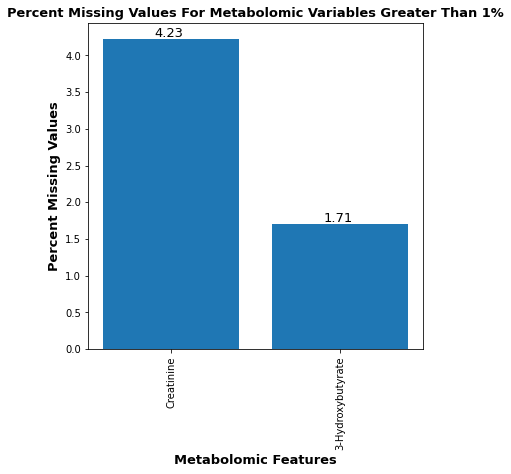

In [25]:
metabolomic_features = ['Creatinine', '3-Hydroxybutyrate']
nan_values_met = [4.23, 1.71]


plt.figure(figsize=(6,6))
for i, v in enumerate(nan_values_met):
    plt.text(i - 0.1, v + 0.03, str(v), fontsize = 13)
plt.bar(metabolomic_features, nan_values_met)
plt.title('Percent Missing Values For Metabolomic Variables Greater Than 1%', fontsize = 13, fontweight = 'bold')
plt.xlabel('Metabolomic Features', fontsize = 13, fontweight = 'bold')
plt.xticks(rotation = 90)
plt.ylabel('Percent Missing Values', fontsize = 13, fontweight = 'bold')

plt.savefig('Paper1_metabolomic_missing_values_over_one_percent.png', bbox_inches = 'tight')
plt.show()

Below we make a new list of the float columns so we can fill all NaN values.

In [26]:
pd.options.display.max_rows = 10
floats_final = prediabetes_with_metabolomics_continuous_only_to_keep_filtered.select_dtypes(include=['float64']).columns.to_list()
floats_final

['23400-0.0',
 '23401-0.0',
 '23402-0.0',
 '23403-0.0',
 '23404-0.0',
 '23405-0.0',
 '23406-0.0',
 '23407-0.0',
 '23408-0.0',
 '23409-0.0',
 '23410-0.0',
 '23411-0.0',
 '23412-0.0',
 '23413-0.0',
 '23414-0.0',
 '23415-0.0',
 '23416-0.0',
 '23417-0.0',
 '23418-0.0',
 '23419-0.0',
 '23420-0.0',
 '23421-0.0',
 '23422-0.0',
 '23423-0.0',
 '23424-0.0',
 '23425-0.0',
 '23426-0.0',
 '23427-0.0',
 '23428-0.0',
 '23429-0.0',
 '23430-0.0',
 '23431-0.0',
 '23432-0.0',
 '23433-0.0',
 '23434-0.0',
 '23436-0.0',
 '23437-0.0',
 '23438-0.0',
 '23439-0.0',
 '23440-0.0',
 '23442-0.0',
 '23443-0.0',
 '23444-0.0',
 '23445-0.0',
 '23446-0.0',
 '23447-0.0',
 '23448-0.0',
 '23449-0.0',
 '23450-0.0',
 '23460-0.0',
 '23461-0.0',
 '23462-0.0',
 '23463-0.0',
 '23464-0.0',
 '23465-0.0',
 '23466-0.0',
 '23467-0.0',
 '23468-0.0',
 '23469-0.0',
 '23470-0.0',
 '23471-0.0',
 '23472-0.0',
 '23473-0.0',
 '23474-0.0',
 '23475-0.0',
 '23476-0.0',
 '23477-0.0',
 '23478-0.0',
 '23479-0.0',
 '23480-0.0',
 '23481-0.0',
 '2348

<a class="anchor" id="KNN_Imputer"></a>
Next we perform Imputation Using k-NN with k = 5. Implementation from: https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/

In [27]:
from sklearn.impute import KNNImputer

prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn = prediabetes_with_metabolomics_continuous_only_to_keep_filtered.drop(columns = ['eid', 'target'])

# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn)

# transform the dataset
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final = imputer.transform(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final

array([[5.0722  , 3.6887  , 1.8404  , ..., 0.29572 , 0.11002 , 0.04743 ],
       [3.7716  , 2.4546  , 1.109   , ..., 0.32234 , 0.10394 , 0.035841],
       [4.519   , 3.5896  , 1.7915  , ..., 0.28809 , 0.11022 , 0.083784],
       ...,
       [3.5629  , 2.6253  , 1.2123  , ..., 0.32932 , 0.11802 , 0.082007],
       [4.071   , 2.8931  , 1.3145  , ..., 0.36378 , 0.12425 , 0.071392],
       [5.1455  , 3.3451  , 1.4854  , ..., 0.39495 , 0.13097 , 0.037247]])

Below we create a dataframe of these values.

In [28]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df = pd.DataFrame(data=prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final, columns=prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn.columns)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df

,23400-0.0,23401-0.0,23402-0.0,23403-0.0,23404-0.0,23405-0.0,23406-0.0,23407-0.0,23408-0.0,23409-0.0,...,23569-0.0,23570-0.0,23571-0.0,23572-0.0,23573-0.0,23574-0.0,23575-0.0,23576-0.0,23577-0.0,23578-0.0
0,5.0722,3.6887,1.8404,0.84379,2.8117,1.84830,1.38350,1.05560,0.65250,0.14697,...,0.40360,0.089485,0.053400,0.008862,1.07220,0.61907,0.40574,0.29572,0.110020,0.047430
1,3.7716,2.4546,1.1090,0.42269,1.9801,1.34560,1.31700,0.72558,0.44415,0.11384,...,0.41526,0.083232,0.033200,0.009097,1.07350,0.61140,0.42628,0.32234,0.103940,0.035841
2,4.5190,3.5896,1.7915,0.97591,2.5595,1.79800,0.92939,2.13880,1.54990,0.21661,...,0.29014,0.065946,0.086861,0.009035,1.14000,0.65788,0.39831,0.28809,0.110220,0.083784
3,4.9518,3.1492,1.3743,0.45402,2.6832,1.77490,1.80260,0.56713,0.31040,0.11897,...,0.50841,0.108500,0.016658,0.009099,1.01750,0.56630,0.43184,0.31848,0.113370,0.019326
4,2.9259,1.8478,0.8703,0.35565,1.3400,0.97753,1.07800,0.92902,0.69337,0.08373,...,0.34595,0.066720,0.035421,0.008057,0.97235,0.56304,0.37241,0.28323,0.089176,0.036902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334,5.5147,4.2459,2.1481,1.08270,3.2354,2.09780,1.26890,1.63230,1.15280,0.17546,...,0.39407,0.087251,0.069017,0.010124,1.22800,0.70412,0.45917,0.33805,0.121120,0.064663
2335,4.0321,2.8769,1.3677,0.64201,2.1882,1.50910,1.15530,1.27490,0.91217,0.13757,...,0.38089,0.078563,0.050539,0.009690,1.17340,0.67604,0.44390,0.33278,0.111120,0.053463
2336,3.5629,2.6253,1.2123,0.67483,1.7881,1.41300,0.93761,2.31370,1.80970,0.18737,...,0.33310,0.071334,0.075526,0.010021,1.25460,0.72523,0.44733,0.32932,0.118020,0.082007
2337,4.0710,2.8931,1.3145,0.72080,2.0921,1.57860,1.17800,1.97550,1.52290,0.17258,...,0.40807,0.085483,0.065454,0.010734,1.31230,0.75289,0.48803,0.36378,0.124250,0.071392


Below we show which metabolomic data distributions are normal and which are not normal using the Shapiro-Wilk test. This is important for our statistical testing further on.

In [29]:
import scipy.stats as stats

normal_metabolites = []
not_normal_metabolites = []

for col in prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df.columns:
    w, pvalue = stats.shapiro(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col])
    print('For feature:', col, 'Shapiro test statistic is:', w, 'With padjusted (pval*168):', pvalue)
    if pvalue*168 < 0.05:
        not_normal_metabolites.append(col)
        print('-------------------NOT NORMAL-----------------')
    else:
        normal_metabolites.append(col)
        print('-------------------NORMAL-----------------')

For feature: 23400-0.0 Shapiro test statistic is: 0.9926098585128784 With padjusted (pval*168): 1.6382571965678494e-09
-------------------NOT NORMAL-----------------
For feature: 23401-0.0 Shapiro test statistic is: 0.9882523417472839 With padjusted (pval*168): 6.110207825815728e-13
-------------------NOT NORMAL-----------------
For feature: 23402-0.0 Shapiro test statistic is: 0.9865480065345764 With padjusted (pval*168): 4.687404774766403e-14
-------------------NOT NORMAL-----------------
For feature: 23403-0.0 Shapiro test statistic is: 0.9841951131820679 With padjusted (pval*168): 1.8934386038091866e-15
-------------------NOT NORMAL-----------------
For feature: 23404-0.0 Shapiro test statistic is: 0.9892460107803345 With padjusted (pval*168): 3.0611492073812085e-12
-------------------NOT NORMAL-----------------
For feature: 23405-0.0 Shapiro test statistic is: 0.9900402426719666 With padjusted (pval*168): 1.190730760519676e-11
-------------------NOT NORMAL-----------------
For fea

For feature: 23460-0.0 Shapiro test statistic is: 0.988315999507904 With padjusted (pval*168): 6.756170059171729e-13
-------------------NOT NORMAL-----------------
For feature: 23461-0.0 Shapiro test statistic is: 0.9958756566047668 With padjusted (pval*168): 4.820469712285558e-06
-------------------NOT NORMAL-----------------
For feature: 23462-0.0 Shapiro test statistic is: 0.9248075485229492 With padjusted (pval*168): 1.0519019931560691e-32
-------------------NOT NORMAL-----------------
For feature: 23463-0.0 Shapiro test statistic is: 0.8674162030220032 With padjusted (pval*168): 1.114564772554673e-40
-------------------NOT NORMAL-----------------
For feature: 23464-0.0 Shapiro test statistic is: 0.9475915431976318 With padjusted (pval*168): 4.214772016362594e-28
-------------------NOT NORMAL-----------------
For feature: 23465-0.0 Shapiro test statistic is: 0.9117856025695801 With padjusted (pval*168): 7.380280440621527e-35
-------------------NOT NORMAL-----------------
For featur

For feature: 23510-0.0 Shapiro test statistic is: 0.9801120162010193 With padjusted (pval*168): 1.4608773932572468e-17
-------------------NOT NORMAL-----------------
For feature: 23511-0.0 Shapiro test statistic is: 0.9845162034034729 With padjusted (pval*168): 2.875694643620242e-15
-------------------NOT NORMAL-----------------
For feature: 23512-0.0 Shapiro test statistic is: 0.981955885887146 With padjusted (pval*168): 1.1944274963539926e-16
-------------------NOT NORMAL-----------------
For feature: 23513-0.0 Shapiro test statistic is: 0.9818296432495117 With padjusted (pval*168): 1.0295748339602575e-16
-------------------NOT NORMAL-----------------
For feature: 23514-0.0 Shapiro test statistic is: 0.982912540435791 With padjusted (pval*168): 3.7715605755309696e-16
-------------------NOT NORMAL-----------------
For feature: 23515-0.0 Shapiro test statistic is: 0.9604519605636597 With padjusted (pval*168): 9.114400291310418e-25
-------------------NOT NORMAL-----------------
For feat

For feature: 23559-0.0 Shapiro test statistic is: 0.8742889761924744 With padjusted (pval*168): 6.826635663727995e-40
-------------------NOT NORMAL-----------------
For feature: 23560-0.0 Shapiro test statistic is: 0.8893828392028809 With padjusted (pval*168): 4.930321230128422e-38
-------------------NOT NORMAL-----------------
For feature: 23561-0.0 Shapiro test statistic is: 0.8655694127082825 With padjusted (pval*168): 6.938108956565034e-41
-------------------NOT NORMAL-----------------
For feature: 23562-0.0 Shapiro test statistic is: 0.8669090270996094 With padjusted (pval*168): 9.780222501908628e-41
-------------------NOT NORMAL-----------------
For feature: 23563-0.0 Shapiro test statistic is: 0.8734933733940125 With padjusted (pval*168): 5.512301782099176e-40
-------------------NOT NORMAL-----------------
For feature: 23564-0.0 Shapiro test statistic is: 0.9247781038284302 With padjusted (pval*168): 1.039404651496905e-32
-------------------NOT NORMAL-----------------
For featur

Now we have to normalize all the float columns so that they have values between 0 and 1. We do this by dividing each value in a column by using min-max normalization.

In [30]:
for col in floats_final:
    prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col] = (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col] - prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col].min()) / (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col].max() - prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col].min())
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df

,23400-0.0,23401-0.0,23402-0.0,23403-0.0,23404-0.0,23405-0.0,23406-0.0,23407-0.0,23408-0.0,23409-0.0,...,23569-0.0,23570-0.0,23571-0.0,23572-0.0,23573-0.0,23574-0.0,23575-0.0,23576-0.0,23577-0.0,23578-0.0
0,0.484941,0.448143,0.454182,0.383128,0.503289,0.502098,0.374557,0.133833,0.111934,0.168066,...,0.330396,0.363306,0.235669,0.243458,0.228702,0.226876,0.250734,0.244515,0.321751,0.224446
1,0.302067,0.250503,0.216074,0.160176,0.350962,0.360633,0.345652,0.073043,0.067466,0.103913,...,0.344825,0.330879,0.127482,0.261577,0.229491,0.219080,0.284609,0.301056,0.279932,0.160634
2,0.407157,0.432272,0.438263,0.453080,0.457093,0.487943,0.177170,0.333359,0.303467,0.302916,...,0.189997,0.241236,0.414881,0.256776,0.269833,0.266324,0.238480,0.228309,0.323126,0.424620
3,0.468012,0.361743,0.302443,0.176763,0.479751,0.481443,0.556726,0.043856,0.038919,0.113847,...,0.460093,0.461915,0.038885,0.261708,0.195518,0.173240,0.293779,0.292857,0.344792,0.069699
4,0.183155,0.153325,0.138365,0.124681,0.233713,0.257054,0.241766,0.110517,0.120657,0.045608,...,0.259058,0.245250,0.139377,0.181507,0.168128,0.169926,0.195765,0.217986,0.178384,0.166476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334,0.547160,0.537378,0.554354,0.509620,0.580900,0.572311,0.324744,0.240061,0.218714,0.223234,...,0.318604,0.351721,0.319311,0.340555,0.323218,0.313323,0.338853,0.334424,0.398098,0.319335
2335,0.338695,0.318134,0.300294,0.276295,0.389081,0.406644,0.275366,0.174228,0.167356,0.149864,...,0.302294,0.306666,0.220346,0.307195,0.290095,0.284782,0.313669,0.323230,0.329317,0.257665
2336,0.272722,0.277841,0.249704,0.293672,0.315793,0.379600,0.180743,0.365576,0.358917,0.246296,...,0.243157,0.269177,0.354173,0.332631,0.339355,0.334780,0.319326,0.315881,0.376775,0.414835
2337,0.344165,0.320729,0.282975,0.318011,0.371478,0.426202,0.285233,0.303279,0.297705,0.217657,...,0.335928,0.342552,0.300229,0.387488,0.374359,0.362894,0.386450,0.389074,0.419626,0.356386


Below we add the eid column back.

In [31]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df['eid'] = prediabetes_with_metabolomics_continuous_only_to_keep_filtered.reset_index(inplace = False)['eid']
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df

,23400-0.0,23401-0.0,23402-0.0,23403-0.0,23404-0.0,23405-0.0,23406-0.0,23407-0.0,23408-0.0,23409-0.0,...,23570-0.0,23571-0.0,23572-0.0,23573-0.0,23574-0.0,23575-0.0,23576-0.0,23577-0.0,23578-0.0,eid
0,0.484941,0.448143,0.454182,0.383128,0.503289,0.502098,0.374557,0.133833,0.111934,0.168066,...,0.363306,0.235669,0.243458,0.228702,0.226876,0.250734,0.244515,0.321751,0.224446,1000809
1,0.302067,0.250503,0.216074,0.160176,0.350962,0.360633,0.345652,0.073043,0.067466,0.103913,...,0.330879,0.127482,0.261577,0.229491,0.219080,0.284609,0.301056,0.279932,0.160634,1005686
2,0.407157,0.432272,0.438263,0.453080,0.457093,0.487943,0.177170,0.333359,0.303467,0.302916,...,0.241236,0.414881,0.256776,0.269833,0.266324,0.238480,0.228309,0.323126,0.424620,1005936
3,0.468012,0.361743,0.302443,0.176763,0.479751,0.481443,0.556726,0.043856,0.038919,0.113847,...,0.461915,0.038885,0.261708,0.195518,0.173240,0.293779,0.292857,0.344792,0.069699,1007333
4,0.183155,0.153325,0.138365,0.124681,0.233713,0.257054,0.241766,0.110517,0.120657,0.045608,...,0.245250,0.139377,0.181507,0.168128,0.169926,0.195765,0.217986,0.178384,0.166476,1016167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334,0.547160,0.537378,0.554354,0.509620,0.580900,0.572311,0.324744,0.240061,0.218714,0.223234,...,0.351721,0.319311,0.340555,0.323218,0.313323,0.338853,0.334424,0.398098,0.319335,6017696
2335,0.338695,0.318134,0.300294,0.276295,0.389081,0.406644,0.275366,0.174228,0.167356,0.149864,...,0.306666,0.220346,0.307195,0.290095,0.284782,0.313669,0.323230,0.329317,0.257665,6017753
2336,0.272722,0.277841,0.249704,0.293672,0.315793,0.379600,0.180743,0.365576,0.358917,0.246296,...,0.269177,0.354173,0.332631,0.339355,0.334780,0.319326,0.315881,0.376775,0.414835,6017871
2337,0.344165,0.320729,0.282975,0.318011,0.371478,0.426202,0.285233,0.303279,0.297705,0.217657,...,0.342552,0.300229,0.387488,0.374359,0.362894,0.386450,0.389074,0.419626,0.356386,6018114


Below we create a list of these eid numbers.

In [32]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df_with_eid = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df_with_eid

[1000809,
 1005686,
 1005936,
 1007333,
 1016167,
 1017443,
 1018119,
 1025405,
 1025738,
 1026007,
 1027978,
 1030454,
 1034056,
 1035811,
 1036940,
 1037932,
 1039510,
 1040950,
 1041652,
 1042924,
 1043213,
 1045764,
 1046313,
 1048428,
 1049423,
 1049710,
 1050906,
 1052513,
 1056375,
 1056980,
 1062604,
 1063648,
 1063856,
 1068154,
 1068882,
 1069867,
 1072504,
 1073266,
 1075104,
 1075927,
 1076087,
 1077768,
 1082613,
 1084010,
 1086687,
 1087122,
 1087380,
 1090737,
 1094263,
 1094700,
 1097020,
 1098087,
 1099030,
 1099336,
 1099911,
 1101247,
 1102293,
 1102744,
 1102863,
 1104962,
 1106386,
 1107380,
 1115680,
 1116252,
 1117967,
 1120584,
 1120681,
 1125079,
 1125452,
 1128480,
 1128721,
 1130724,
 1137127,
 1145728,
 1147334,
 1148003,
 1149894,
 1150077,
 1151556,
 1151952,
 1155943,
 1157575,
 1168769,
 1169079,
 1169859,
 1174474,
 1177141,
 1177496,
 1179607,
 1185015,
 1192821,
 1193061,
 1196100,
 1196563,
 1200313,
 1201409,
 1201497,
 1202179,
 1202941,
 1204760,


<a class="anchor" id="Adding_covariates"></a>
# Below we account for covariates of sex, age, and ethnic backgound.

Below we add the sex, ethnicity, and age information to the dataframe. We will use these later on to account for the covariates and see if this changes the results of the model.

In [33]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df.merge(prediabetes_with_features[['eid', '31-0.0', '21003-0.0', '21000-0.0', '1647-0.0']], on = 'eid')
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates

,23400-0.0,23401-0.0,23402-0.0,23403-0.0,23404-0.0,23405-0.0,23406-0.0,23407-0.0,23408-0.0,23409-0.0,...,23574-0.0,23575-0.0,23576-0.0,23577-0.0,23578-0.0,eid,31-0.0,21003-0.0,21000-0.0,1647-0.0
0,0.484941,0.448143,0.454182,0.383128,0.503289,0.502098,0.374557,0.133833,0.111934,0.168066,...,0.226876,0.250734,0.244515,0.321751,0.224446,1000809,0,50,3001.0,1.0
1,0.302067,0.250503,0.216074,0.160176,0.350962,0.360633,0.345652,0.073043,0.067466,0.103913,...,0.219080,0.284609,0.301056,0.279932,0.160634,1005686,0,67,1001.0,1.0
2,0.407157,0.432272,0.438263,0.453080,0.457093,0.487943,0.177170,0.333359,0.303467,0.302916,...,0.266324,0.238480,0.228309,0.323126,0.424620,1005936,1,61,1001.0,1.0
3,0.468012,0.361743,0.302443,0.176763,0.479751,0.481443,0.556726,0.043856,0.038919,0.113847,...,0.173240,0.293779,0.292857,0.344792,0.069699,1007333,1,57,4001.0,6.0
4,0.183155,0.153325,0.138365,0.124681,0.233713,0.257054,0.241766,0.110517,0.120657,0.045608,...,0.169926,0.195765,0.217986,0.178384,0.166476,1016167,0,64,3001.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334,0.547160,0.537378,0.554354,0.509620,0.580900,0.572311,0.324744,0.240061,0.218714,0.223234,...,0.313323,0.338853,0.334424,0.398098,0.319335,6017696,0,61,6.0,6.0
2335,0.338695,0.318134,0.300294,0.276295,0.389081,0.406644,0.275366,0.174228,0.167356,0.149864,...,0.284782,0.313669,0.323230,0.329317,0.257665,6017753,1,55,6.0,6.0
2336,0.272722,0.277841,0.249704,0.293672,0.315793,0.379600,0.180743,0.365576,0.358917,0.246296,...,0.334780,0.319326,0.315881,0.376775,0.414835,6017871,1,50,1001.0,1.0
2337,0.344165,0.320729,0.282975,0.318011,0.371478,0.426202,0.285233,0.303279,0.297705,0.217657,...,0.362894,0.386450,0.389074,0.419626,0.356386,6018114,0,61,1001.0,1.0


Below we add the target column to our dataframe.

In [34]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['target'] = prediabetes_with_metabolomics_continuous_only_to_keep_filtered.reset_index()['target']
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates

,23400-0.0,23401-0.0,23402-0.0,23403-0.0,23404-0.0,23405-0.0,23406-0.0,23407-0.0,23408-0.0,23409-0.0,...,23575-0.0,23576-0.0,23577-0.0,23578-0.0,eid,31-0.0,21003-0.0,21000-0.0,1647-0.0,target
0,0.484941,0.448143,0.454182,0.383128,0.503289,0.502098,0.374557,0.133833,0.111934,0.168066,...,0.250734,0.244515,0.321751,0.224446,1000809,0,50,3001.0,1.0,1
1,0.302067,0.250503,0.216074,0.160176,0.350962,0.360633,0.345652,0.073043,0.067466,0.103913,...,0.284609,0.301056,0.279932,0.160634,1005686,0,67,1001.0,1.0,1
2,0.407157,0.432272,0.438263,0.453080,0.457093,0.487943,0.177170,0.333359,0.303467,0.302916,...,0.238480,0.228309,0.323126,0.424620,1005936,1,61,1001.0,1.0,1
3,0.468012,0.361743,0.302443,0.176763,0.479751,0.481443,0.556726,0.043856,0.038919,0.113847,...,0.293779,0.292857,0.344792,0.069699,1007333,1,57,4001.0,6.0,0
4,0.183155,0.153325,0.138365,0.124681,0.233713,0.257054,0.241766,0.110517,0.120657,0.045608,...,0.195765,0.217986,0.178384,0.166476,1016167,0,64,3001.0,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334,0.547160,0.537378,0.554354,0.509620,0.580900,0.572311,0.324744,0.240061,0.218714,0.223234,...,0.338853,0.334424,0.398098,0.319335,6017696,0,61,6.0,6.0,0
2335,0.338695,0.318134,0.300294,0.276295,0.389081,0.406644,0.275366,0.174228,0.167356,0.149864,...,0.313669,0.323230,0.329317,0.257665,6017753,1,55,6.0,6.0,0
2336,0.272722,0.277841,0.249704,0.293672,0.315793,0.379600,0.180743,0.365576,0.358917,0.246296,...,0.319326,0.315881,0.376775,0.414835,6017871,1,50,1001.0,1.0,1
2337,0.344165,0.320729,0.282975,0.318011,0.371478,0.426202,0.285233,0.303279,0.297705,0.217657,...,0.386450,0.389074,0.419626,0.356386,6018114,0,61,1001.0,1.0,0


Below we split our dataframe into progressors and non progressors.

In [35]:
prediabetes_with_features_diabetes = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['target'] == 1]
prediabetes_with_features_no_diabetes = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['target'] == 0]

<a class="anchor" id="Progressors"></a>
## We first find all above responses for patients who progress to a diabetic state

First is sex.

In [36]:
# 479 females
print(prediabetes_with_features_diabetes[prediabetes_with_features_diabetes['31-0.0'] == 0].shape)
# 617 Males
print(prediabetes_with_features_diabetes[prediabetes_with_features_diabetes['31-0.0'] == 1].shape)

(479, 174)
(617, 174)


Below we test if sex is different between group 1 and all other groups. The code is implemented from https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

In [37]:
# Make contigency table comparing group 1 and other group number of males and females
table = [[len(prediabetes_with_features_diabetes[prediabetes_with_features_diabetes['31-0.0'] == 0]), len(prediabetes_with_features_no_diabetes[prediabetes_with_features_no_diabetes['31-0.0'] == 0])],
         [len(prediabetes_with_features_diabetes[prediabetes_with_features_diabetes['31-0.0'] == 1]),  len(prediabetes_with_features_no_diabetes[prediabetes_with_features_no_diabetes['31-0.0'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*7 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')


[[479, 680], [617, 563]]
dof=1
[[543.0799487 615.9200513]
 [552.9200513 627.0799487]]
probability=0.950, critical=3.841, stat=27.764
Dependent (reject H0)
significance=0.050, p=0.00000
Dependent (reject H0)


Next is the age distribution. We cut age into different sections which are < 45, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, >75

In [38]:
print(prediabetes_with_features_diabetes[prediabetes_with_features_diabetes['21003-0.0'] < 45].shape)
print(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21003-0.0'] >= 45) & (prediabetes_with_features_diabetes['21003-0.0'] < 49)].shape)
print(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21003-0.0'] >= 50) & (prediabetes_with_features_diabetes['21003-0.0'] <= 54)].shape)
print(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21003-0.0'] >= 55) & (prediabetes_with_features_diabetes['21003-0.0'] <= 59)].shape)
print(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21003-0.0'] >= 60) & (prediabetes_with_features_diabetes['21003-0.0'] <= 64)].shape)
print(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21003-0.0'] >= 65) & (prediabetes_with_features_diabetes['21003-0.0'] <= 69)].shape)
print(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21003-0.0'] >= 70) & (prediabetes_with_features_diabetes['21003-0.0'] <= 74)].shape)
print(prediabetes_with_features_diabetes[prediabetes_with_features_diabetes['21003-0.0'] >= 75].shape)

(42, 174)
(49, 174)
(124, 174)
(204, 174)
(305, 174)
(344, 174)
(12, 174)
(0, 174)


Below we find the average and standard deviation of the age.

In [39]:
print('Average age for progressors is:', prediabetes_with_features_diabetes['21003-0.0'].mean())
print('Standard deviation of age for progressors is:', np.std(prediabetes_with_features_diabetes['21003-0.0']))

Average age for progressors is: 60.11040145985402
Standard deviation of age for progressors is: 6.989019112865407


Next is ethnicity.

In [40]:
# 974 whites
print(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21000-0.0'] == 1) | (prediabetes_with_features_diabetes['21000-0.0'] == 1001) | (prediabetes_with_features_diabetes['21000-0.0'] == 2001) | (prediabetes_with_features_diabetes['21000-0.0'] == 3001) | (prediabetes_with_features_diabetes['21000-0.0'] == 4001)].shape)
# 50 mixed
print(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21000-0.0'] == 2) | (prediabetes_with_features_diabetes['21000-0.0'] == 1002) | (prediabetes_with_features_diabetes['21000-0.0'] == 2002) | (prediabetes_with_features_diabetes['21000-0.0'] == 3002) | (prediabetes_with_features_diabetes['21000-0.0'] == 4002)].shape)
# 26 Asian or Asian British
print(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21000-0.0'] == 3) | (prediabetes_with_features_diabetes['21000-0.0'] == 1003) | (prediabetes_with_features_diabetes['21000-0.0'] == 2003) | (prediabetes_with_features_diabetes['21000-0.0'] == 3003) | (prediabetes_with_features_diabetes['21000-0.0'] == 4003)].shape)
# 9 Black or Black British
print(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21000-0.0'] == 4) | (prediabetes_with_features_diabetes['21000-0.0'] == 2004) | (prediabetes_with_features_diabetes['21000-0.0'] == 3004)].shape)
# 7 Chinese
print(prediabetes_with_features_diabetes[prediabetes_with_features_diabetes['21000-0.0'] == 5].shape)
# 18 Other Ethnic Group
print(prediabetes_with_features_diabetes[prediabetes_with_features_diabetes['21000-0.0'] == 6].shape)

# 12 Unknown - Those that are leftover

(974, 174)
(50, 174)
(26, 174)
(9, 174)
(7, 174)
(18, 174)


Next is country of birth.

In [41]:
# 837 England
print(prediabetes_with_features_diabetes[prediabetes_with_features_diabetes['1647-0.0'] == 1].shape)
# 28 Wales
print(prediabetes_with_features_diabetes[prediabetes_with_features_diabetes['1647-0.0'] == 2].shape)
# 59 Scotland
print(prediabetes_with_features_diabetes[prediabetes_with_features_diabetes['1647-0.0'] == 3].shape)
# 5 Northern Ireland
print(prediabetes_with_features_diabetes[prediabetes_with_features_diabetes['1647-0.0'] == 4].shape)
# 15 Republic of Ireland
print(prediabetes_with_features_diabetes[prediabetes_with_features_diabetes['1647-0.0'] == 5].shape)
# 142 Elsewhere
print(prediabetes_with_features_diabetes[prediabetes_with_features_diabetes['1647-0.0'] == 6].shape)

# 10 Unknown 

(837, 174)
(28, 174)
(59, 174)
(5, 174)
(15, 174)
(142, 174)


## Below we find all above responses for patients who do NOT progress to a diabetic state

First is sex.

In [42]:
# 680 females
print(prediabetes_with_features_no_diabetes[prediabetes_with_features_no_diabetes['31-0.0'] == 0].shape)
# 563 Males
print(prediabetes_with_features_no_diabetes[prediabetes_with_features_no_diabetes['31-0.0'] == 1].shape)

(680, 174)
(563, 174)


Next is the age distribution. We cut age into different sections which are < 45, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, >75

In [43]:
print(prediabetes_with_features_no_diabetes[prediabetes_with_features_no_diabetes['21003-0.0'] < 45].shape)
print(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21003-0.0'] >= 45) & (prediabetes_with_features_no_diabetes['21003-0.0'] < 49)].shape)
print(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21003-0.0'] >= 50) & (prediabetes_with_features_no_diabetes['21003-0.0'] <= 54)].shape)
print(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21003-0.0'] >= 55) & (prediabetes_with_features_no_diabetes['21003-0.0'] <= 59)].shape)
print(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21003-0.0'] >= 60) & (prediabetes_with_features_no_diabetes['21003-0.0'] <= 64)].shape)
print(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21003-0.0'] >= 65) & (prediabetes_with_features_no_diabetes['21003-0.0'] <= 69)].shape)
print(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21003-0.0'] >= 70) & (prediabetes_with_features_no_diabetes['21003-0.0'] <= 74)].shape)
print(prediabetes_with_features_no_diabetes[prediabetes_with_features_no_diabetes['21003-0.0'] >= 75].shape)

(55, 174)
(52, 174)
(123, 174)
(202, 174)
(390, 174)
(391, 174)
(9, 174)
(0, 174)


Below we find the average and standard deviation of the age.

In [44]:
print('Average age for non-progressors is:', prediabetes_with_features_no_diabetes['21003-0.0'].mean())
print('Standard deviation of age for non-progressors is:', np.std(prediabetes_with_features_no_diabetes['21003-0.0']))

Average age for non-progressors is: 60.12711182622687
Standard deviation of age for non-progressors is: 7.0384483870430286


Next is ethnicity.

In [45]:
# 1107 whites
print(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21000-0.0'] == 1) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 1001) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 2001) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 3001) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 4001)].shape)
# 49 mixed
print(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21000-0.0'] == 2) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 1002) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 2002) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 3002) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 4002)].shape)
# 46 Asian or Asian British
print(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21000-0.0'] == 3) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 1003) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 2003) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 3003) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 4003)].shape)
# 13 Black or Black British
print(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21000-0.0'] == 4) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 2004) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 3004)].shape)
# 5 Chinese
print(prediabetes_with_features_no_diabetes[prediabetes_with_features_no_diabetes['21000-0.0'] == 5].shape)
# 17 Other Ethnic Group
print(prediabetes_with_features_no_diabetes[prediabetes_with_features_no_diabetes['21000-0.0'] == 6].shape)

# 6 Unknown - Those that are leftover

(1107, 174)
(49, 174)
(46, 174)
(13, 174)
(5, 174)
(17, 174)


Next is country of birth.

In [46]:
# 941 England
print(prediabetes_with_features_no_diabetes[prediabetes_with_features_no_diabetes['1647-0.0'] == 1].shape)
# 22 Wales
print(prediabetes_with_features_no_diabetes[prediabetes_with_features_no_diabetes['1647-0.0'] == 2].shape)
# 115 Scotland
print(prediabetes_with_features_no_diabetes[prediabetes_with_features_no_diabetes['1647-0.0'] == 3].shape)
# 5 Northern Ireland
print(prediabetes_with_features_no_diabetes[prediabetes_with_features_no_diabetes['1647-0.0'] == 4].shape)
# 10 Republic of Ireland
print(prediabetes_with_features_no_diabetes[prediabetes_with_features_no_diabetes['1647-0.0'] == 5].shape)
# 146 Elsewhere
print(prediabetes_with_features_no_diabetes[prediabetes_with_features_no_diabetes['1647-0.0'] == 6].shape)

# 4 Unknown 

(941, 174)
(22, 174)
(115, 174)
(5, 174)
(10, 174)
(146, 174)


Below we test if ethnicity is different between group 1 and all other groups. The code is implemented from https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

First is for whites.

In [47]:
# Make contigency table comparing group 1 and other group number of males and females
table = [[len(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21000-0.0'] == 1) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 1001) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 2001) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 3001) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 4001)]), len(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21000-0.0'] == 1) | (prediabetes_with_features_diabetes['21000-0.0'] == 1001) | (prediabetes_with_features_diabetes['21000-0.0'] == 2001) | (prediabetes_with_features_diabetes['21000-0.0'] == 3001) | (prediabetes_with_features_diabetes['21000-0.0'] == 4001)])],
         [len(prediabetes_with_features_no_diabetes[~(prediabetes_with_features_no_diabetes['21000-0.0'] == 1) & ~(prediabetes_with_features_no_diabetes['21000-0.0'] == 1001) & ~(prediabetes_with_features_no_diabetes['21000-0.0'] == 2001) & ~(prediabetes_with_features_no_diabetes['21000-0.0'] == 3001) & ~(prediabetes_with_features_no_diabetes['21000-0.0'] == 4001)]),  len(prediabetes_with_features_diabetes[~(prediabetes_with_features_diabetes['21000-0.0'] == 1) & ~(prediabetes_with_features_diabetes['21000-0.0'] == 1001) & ~(prediabetes_with_features_diabetes['21000-0.0'] == 2001) & ~(prediabetes_with_features_diabetes['21000-0.0'] == 3001) & ~(prediabetes_with_features_diabetes['21000-0.0'] == 4001)])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*7 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')


[[1107, 974], [136, 122]]
dof=1
[[1105.89268918  975.10731082]
 [ 137.10731082  120.89268918]]
probability=0.950, critical=3.841, stat=0.006
Independent (fail to reject H0)
significance=0.050, p=0.93598
Independent (fail to reject H0)


Next is for mixed.

In [48]:
# Make contigency table comparing group 1 and other group number of males and females
table = [[len(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21000-0.0'] == 2) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 1002) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 2002) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 3002) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 4002)]), len(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21000-0.0'] == 2) | (prediabetes_with_features_diabetes['21000-0.0'] == 1002) | (prediabetes_with_features_diabetes['21000-0.0'] == 2002) | (prediabetes_with_features_diabetes['21000-0.0'] == 3002) | (prediabetes_with_features_diabetes['21000-0.0'] == 4002)])],
         [len(prediabetes_with_features_no_diabetes[~(prediabetes_with_features_no_diabetes['21000-0.0'] == 2) & ~(prediabetes_with_features_no_diabetes['21000-0.0'] == 1002) & ~(prediabetes_with_features_no_diabetes['21000-0.0'] == 2002) & ~(prediabetes_with_features_no_diabetes['21000-0.0'] == 3002) & ~(prediabetes_with_features_no_diabetes['21000-0.0'] == 4002)]),  len(prediabetes_with_features_diabetes[~(prediabetes_with_features_diabetes['21000-0.0'] == 2) & ~(prediabetes_with_features_diabetes['21000-0.0'] == 1002) & ~(prediabetes_with_features_diabetes['21000-0.0'] == 2002) & ~(prediabetes_with_features_diabetes['21000-0.0'] == 3002) & ~(prediabetes_with_features_diabetes['21000-0.0'] == 4002)])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*7 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[49, 50], [1194, 1046]]
dof=1
[[  52.61094485   46.38905515]
 [1190.38905515 1049.61094485]]
probability=0.950, critical=3.841, stat=0.410
Independent (fail to reject H0)
significance=0.050, p=0.52200
Independent (fail to reject H0)


Next is for Asian or Asian British.

In [49]:
# Make contigency table comparing group 1 and other group number of males and females
table = [[len(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21000-0.0'] == 3) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 1003) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 2003) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 3003) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 4003)]), len(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21000-0.0'] == 3) | (prediabetes_with_features_diabetes['21000-0.0'] == 1003) | (prediabetes_with_features_diabetes['21000-0.0'] == 2003) | (prediabetes_with_features_diabetes['21000-0.0'] == 3003) | (prediabetes_with_features_diabetes['21000-0.0'] == 4003)])],
         [len(prediabetes_with_features_no_diabetes[~(prediabetes_with_features_no_diabetes['21000-0.0'] == 3) & ~(prediabetes_with_features_no_diabetes['21000-0.0'] == 1003) & ~(prediabetes_with_features_no_diabetes['21000-0.0'] == 2003) & ~(prediabetes_with_features_no_diabetes['21000-0.0'] == 3003) & ~(prediabetes_with_features_no_diabetes['21000-0.0'] == 4003)]),  len(prediabetes_with_features_diabetes[~(prediabetes_with_features_diabetes['21000-0.0'] == 3) & ~(prediabetes_with_features_diabetes['21000-0.0'] == 1003) & ~(prediabetes_with_features_diabetes['21000-0.0'] == 2003) & ~(prediabetes_with_features_diabetes['21000-0.0'] == 3003) & ~(prediabetes_with_features_diabetes['21000-0.0'] == 4003)])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*7 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[46, 26], [1197, 1070]]
dof=1
[[  38.26250534   33.73749466]
 [1204.73749466 1062.26250534]]
probability=0.950, critical=3.841, stat=3.014
Independent (fail to reject H0)
significance=0.050, p=0.08253
Independent (fail to reject H0)


Next is for Black or Black British.

In [50]:
# Make contigency table comparing group 1 and other group number of males and females
table = [[len(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21000-0.0'] == 4) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 2004) | (prediabetes_with_features_no_diabetes['21000-0.0'] == 3004)]), len(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21000-0.0'] == 4) | (prediabetes_with_features_diabetes['21000-0.0'] == 2004) | (prediabetes_with_features_diabetes['21000-0.0'] == 3004)])],
         [len(prediabetes_with_features_no_diabetes[~(prediabetes_with_features_no_diabetes['21000-0.0'] == 4) & ~(prediabetes_with_features_no_diabetes['21000-0.0'] == 2004) & ~(prediabetes_with_features_no_diabetes['21000-0.0'] == 3004)]),  len(prediabetes_with_features_diabetes[~(prediabetes_with_features_diabetes['21000-0.0'] == 4) & ~(prediabetes_with_features_diabetes['21000-0.0'] == 2004) & ~(prediabetes_with_features_diabetes['21000-0.0'] == 3004)])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*7 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[13, 9], [1230, 1087]]
dof=1
[[  11.69132108   10.30867892]
 [1231.30867892 1085.69132108]]
probability=0.950, critical=3.841, stat=0.121
Independent (fail to reject H0)
significance=0.050, p=0.72849
Independent (fail to reject H0)


Next is for Chinese.

In [51]:
table = [[len(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21000-0.0'] == 5)]), len(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21000-0.0'] == 5)])],
         [len(prediabetes_with_features_no_diabetes[~(prediabetes_with_features_no_diabetes['21000-0.0'] == 5)]),  len(prediabetes_with_features_diabetes[~(prediabetes_with_features_diabetes['21000-0.0'] == 5)])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*7 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[5, 7], [1238, 1089]]
dof=1
[[   6.37708422    5.62291578]
 [1236.62291578 1090.37708422]]
probability=0.950, critical=3.841, stat=0.259
Independent (fail to reject H0)
significance=0.050, p=0.61097
Independent (fail to reject H0)


Next is for Other.

In [52]:
table = [[len(prediabetes_with_features_no_diabetes[(prediabetes_with_features_no_diabetes['21000-0.0'] == 6)]), len(prediabetes_with_features_diabetes[(prediabetes_with_features_diabetes['21000-0.0'] == 6)])],
         [len(prediabetes_with_features_no_diabetes[~(prediabetes_with_features_no_diabetes['21000-0.0'] == 6)]),  len(prediabetes_with_features_diabetes[~(prediabetes_with_features_diabetes['21000-0.0'] == 6)])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*7 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[17, 18], [1226, 1078]]
dof=1
[[  18.59982899   16.40017101]
 [1224.40017101 1079.59982899]]
probability=0.950, critical=3.841, stat=0.141
Independent (fail to reject H0)
significance=0.050, p=0.70739
Independent (fail to reject H0)


Last is for Unknown.

In [53]:
table = [[6, 12],
         [1237, 1084]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*7 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[6, 12], [1237, 1084]]
dof=1
[[   9.56562634    8.43437366]
 [1233.43437366 1087.56562634]]
probability=0.950, critical=3.841, stat=2.113
Independent (fail to reject H0)
significance=0.050, p=0.14605
Independent (fail to reject H0)


<a class="anchor" id="Groups"></a>
# Below we find the same information but we do so for each of our 7 pre-diabetic unsupervised groups

First, we import the labels for all our pre-diabetic patients.

In [54]:
labels_for_prediabetic_groups = pd.read_csv('prediabetic_patient_eid_and_group_labels.csv')
labels_for_prediabetic_groups = labels_for_prediabetic_groups.drop(columns = 'Unnamed: 0')
labels_for_prediabetic_groups

,eid,labels
0,1281323,5
1,3612804,7
2,4595616,3
3,1908972,5
4,2200802,3
...,...,...
2334,1742251,5
2335,5757336,3
2336,1177141,7
2337,5599911,5


Below we merge the labels on our data.

In [55]:
prediabetics_with_group_labels_and_demographics = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.merge(labels_for_prediabetic_groups, on = 'eid')
prediabetics_with_group_labels_and_demographics

,23400-0.0,23401-0.0,23402-0.0,23403-0.0,23404-0.0,23405-0.0,23406-0.0,23407-0.0,23408-0.0,23409-0.0,...,23576-0.0,23577-0.0,23578-0.0,eid,31-0.0,21003-0.0,21000-0.0,1647-0.0,target,labels
0,0.484941,0.448143,0.454182,0.383128,0.503289,0.502098,0.374557,0.133833,0.111934,0.168066,...,0.244515,0.321751,0.224446,1000809,0,50,3001.0,1.0,1,3
1,0.302067,0.250503,0.216074,0.160176,0.350962,0.360633,0.345652,0.073043,0.067466,0.103913,...,0.301056,0.279932,0.160634,1005686,0,67,1001.0,1.0,1,1
2,0.407157,0.432272,0.438263,0.453080,0.457093,0.487943,0.177170,0.333359,0.303467,0.302916,...,0.228309,0.323126,0.424620,1005936,1,61,1001.0,1.0,1,5
3,0.468012,0.361743,0.302443,0.176763,0.479751,0.481443,0.556726,0.043856,0.038919,0.113847,...,0.292857,0.344792,0.069699,1007333,1,57,4001.0,6.0,0,1
4,0.183155,0.153325,0.138365,0.124681,0.233713,0.257054,0.241766,0.110517,0.120657,0.045608,...,0.217986,0.178384,0.166476,1016167,0,64,3001.0,6.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334,0.547160,0.537378,0.554354,0.509620,0.580900,0.572311,0.324744,0.240061,0.218714,0.223234,...,0.334424,0.398098,0.319335,6017696,0,61,6.0,6.0,0,3
2335,0.338695,0.318134,0.300294,0.276295,0.389081,0.406644,0.275366,0.174228,0.167356,0.149864,...,0.323230,0.329317,0.257665,6017753,1,55,6.0,6.0,0,4
2336,0.272722,0.277841,0.249704,0.293672,0.315793,0.379600,0.180743,0.365576,0.358917,0.246296,...,0.315881,0.376775,0.414835,6017871,1,50,1001.0,1.0,1,7
2337,0.344165,0.320729,0.282975,0.318011,0.371478,0.426202,0.285233,0.303279,0.297705,0.217657,...,0.389074,0.419626,0.356386,6018114,0,61,1001.0,1.0,0,5


Below we create a dataframe for each group.

In [56]:
prediabetics_with_group_labels_and_demographics_group1 = prediabetics_with_group_labels_and_demographics[prediabetics_with_group_labels_and_demographics['labels'] == 1]
prediabetics_with_group_labels_and_demographics_group2 = prediabetics_with_group_labels_and_demographics[prediabetics_with_group_labels_and_demographics['labels'] == 2]
prediabetics_with_group_labels_and_demographics_group3 = prediabetics_with_group_labels_and_demographics[prediabetics_with_group_labels_and_demographics['labels'] == 3]
prediabetics_with_group_labels_and_demographics_group4 = prediabetics_with_group_labels_and_demographics[prediabetics_with_group_labels_and_demographics['labels'] == 4]
prediabetics_with_group_labels_and_demographics_group5 = prediabetics_with_group_labels_and_demographics[prediabetics_with_group_labels_and_demographics['labels'] == 5]
prediabetics_with_group_labels_and_demographics_group6 = prediabetics_with_group_labels_and_demographics[prediabetics_with_group_labels_and_demographics['labels'] == 6]
prediabetics_with_group_labels_and_demographics_group7 = prediabetics_with_group_labels_and_demographics[prediabetics_with_group_labels_and_demographics['labels'] == 7]

Below we show the number of patients in each group.

In [57]:
print('Number of patients in group 1:', len(prediabetics_with_group_labels_and_demographics_group1))
print('Number of patients in group 2:', len(prediabetics_with_group_labels_and_demographics_group2))
print('Number of patients in group 3:', len(prediabetics_with_group_labels_and_demographics_group3))
print('Number of patients in group 4:', len(prediabetics_with_group_labels_and_demographics_group4))
print('Number of patients in group 5:', len(prediabetics_with_group_labels_and_demographics_group5))
print('Number of patients in group 6:', len(prediabetics_with_group_labels_and_demographics_group6))
print('Number of patients in group 7:', len(prediabetics_with_group_labels_and_demographics_group7))

Number of patients in group 1: 341
Number of patients in group 2: 266
Number of patients in group 3: 599
Number of patients in group 4: 250
Number of patients in group 5: 722
Number of patients in group 6: 60
Number of patients in group 7: 101


Below we find all the same information for each group. First is sex.

In [58]:
print('--------------------Group 1---------------------')
print('Number of females in group 1:', len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['31-0.0'] == 0]))
print('Number of males in group 1:', len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['31-0.0'] == 1]))
print('--------------------Group 2---------------------')
print('Number of females in group 2:', len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['31-0.0'] == 0]))
print('Number of males in group 2:', len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['31-0.0'] == 1]))
print('--------------------Group 3---------------------')
print('Number of females in group 3:', len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['31-0.0'] == 0]))
print('Number of males in group 3:', len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['31-0.0'] == 1]))
print('--------------------Group 4---------------------')
print('Number of females in group 4:', len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['31-0.0'] == 0]))
print('Number of males in group 4:', len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['31-0.0'] == 1]))
print('--------------------Group 5---------------------')
print('Number of females in group 5:', len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['31-0.0'] == 0]))
print('Number of males in group 5:', len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['31-0.0'] == 1]))
print('--------------------Group 6---------------------')
print('Number of females in group 6:', len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['31-0.0'] == 0]))
print('Number of males in group 6:', len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['31-0.0'] == 1]))
print('--------------------Group 7---------------------')
print('Number of females in group 7:', len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['31-0.0'] == 0]))
print('Number of males in group 7:', len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['31-0.0'] == 1]))

--------------------Group 1---------------------
Number of females in group 1: 208
Number of males in group 1: 133
--------------------Group 2---------------------
Number of females in group 2: 134
Number of males in group 2: 132
--------------------Group 3---------------------
Number of females in group 3: 387
Number of males in group 3: 212
--------------------Group 4---------------------
Number of females in group 4: 76
Number of males in group 4: 174
--------------------Group 5---------------------
Number of females in group 5: 298
Number of males in group 5: 424
--------------------Group 6---------------------
Number of females in group 6: 30
Number of males in group 6: 30
--------------------Group 7---------------------
Number of females in group 7: 26
Number of males in group 7: 75


Next is the age distribution. We cut age into different sections which are < 45, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, >75

In [59]:
print('--------------------Group 1---------------------')
print(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['21003-0.0'] < 45].shape)
print(prediabetics_with_group_labels_and_demographics_group1[(prediabetics_with_group_labels_and_demographics_group1['21003-0.0'] >= 45) & (prediabetics_with_group_labels_and_demographics_group1['21003-0.0'] < 49)].shape)
print(prediabetics_with_group_labels_and_demographics_group1[(prediabetics_with_group_labels_and_demographics_group1['21003-0.0'] >= 50) & (prediabetics_with_group_labels_and_demographics_group1['21003-0.0'] <= 54)].shape)
print(prediabetics_with_group_labels_and_demographics_group1[(prediabetics_with_group_labels_and_demographics_group1['21003-0.0'] >= 55) & (prediabetics_with_group_labels_and_demographics_group1['21003-0.0'] <= 59)].shape)
print(prediabetics_with_group_labels_and_demographics_group1[(prediabetics_with_group_labels_and_demographics_group1['21003-0.0'] >= 60) & (prediabetics_with_group_labels_and_demographics_group1['21003-0.0'] <= 64)].shape)
print(prediabetics_with_group_labels_and_demographics_group1[(prediabetics_with_group_labels_and_demographics_group1['21003-0.0'] >= 65) & (prediabetics_with_group_labels_and_demographics_group1['21003-0.0'] <= 69)].shape)
print(prediabetics_with_group_labels_and_demographics_group1[(prediabetics_with_group_labels_and_demographics_group1['21003-0.0'] >= 70) & (prediabetics_with_group_labels_and_demographics_group1['21003-0.0'] <= 74)].shape)
print(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['21003-0.0'] >= 75].shape)
print('--------------------Group 2---------------------')
print(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['21003-0.0'] < 45].shape)
print(prediabetics_with_group_labels_and_demographics_group2[(prediabetics_with_group_labels_and_demographics_group2['21003-0.0'] >= 45) & (prediabetics_with_group_labels_and_demographics_group2['21003-0.0'] < 49)].shape)
print(prediabetics_with_group_labels_and_demographics_group2[(prediabetics_with_group_labels_and_demographics_group2['21003-0.0'] >= 50) & (prediabetics_with_group_labels_and_demographics_group2['21003-0.0'] <= 54)].shape)
print(prediabetics_with_group_labels_and_demographics_group2[(prediabetics_with_group_labels_and_demographics_group2['21003-0.0'] >= 55) & (prediabetics_with_group_labels_and_demographics_group2['21003-0.0'] <= 59)].shape)
print(prediabetics_with_group_labels_and_demographics_group2[(prediabetics_with_group_labels_and_demographics_group2['21003-0.0'] >= 60) & (prediabetics_with_group_labels_and_demographics_group2['21003-0.0'] <= 64)].shape)
print(prediabetics_with_group_labels_and_demographics_group2[(prediabetics_with_group_labels_and_demographics_group2['21003-0.0'] >= 65) & (prediabetics_with_group_labels_and_demographics_group2['21003-0.0'] <= 69)].shape)
print(prediabetics_with_group_labels_and_demographics_group2[(prediabetics_with_group_labels_and_demographics_group2['21003-0.0'] >= 70) & (prediabetics_with_group_labels_and_demographics_group2['21003-0.0'] <= 74)].shape)
print(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['21003-0.0'] >= 75].shape)
print('--------------------Group 3---------------------')
print(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['21003-0.0'] < 45].shape)
print(prediabetics_with_group_labels_and_demographics_group3[(prediabetics_with_group_labels_and_demographics_group3['21003-0.0'] >= 45) & (prediabetics_with_group_labels_and_demographics_group3['21003-0.0'] < 49)].shape)
print(prediabetics_with_group_labels_and_demographics_group3[(prediabetics_with_group_labels_and_demographics_group3['21003-0.0'] >= 50) & (prediabetics_with_group_labels_and_demographics_group3['21003-0.0'] <= 54)].shape)
print(prediabetics_with_group_labels_and_demographics_group3[(prediabetics_with_group_labels_and_demographics_group3['21003-0.0'] >= 55) & (prediabetics_with_group_labels_and_demographics_group3['21003-0.0'] <= 59)].shape)
print(prediabetics_with_group_labels_and_demographics_group3[(prediabetics_with_group_labels_and_demographics_group3['21003-0.0'] >= 60) & (prediabetics_with_group_labels_and_demographics_group3['21003-0.0'] <= 64)].shape)
print(prediabetics_with_group_labels_and_demographics_group3[(prediabetics_with_group_labels_and_demographics_group3['21003-0.0'] >= 65) & (prediabetics_with_group_labels_and_demographics_group3['21003-0.0'] <= 69)].shape)
print(prediabetics_with_group_labels_and_demographics_group3[(prediabetics_with_group_labels_and_demographics_group3['21003-0.0'] >= 70) & (prediabetics_with_group_labels_and_demographics_group3['21003-0.0'] <= 74)].shape)
print(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['21003-0.0'] >= 75].shape)
print('--------------------Group 4---------------------')
print(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['21003-0.0'] < 45].shape)
print(prediabetics_with_group_labels_and_demographics_group4[(prediabetics_with_group_labels_and_demographics_group4['21003-0.0'] >= 45) & (prediabetics_with_group_labels_and_demographics_group4['21003-0.0'] < 49)].shape)
print(prediabetics_with_group_labels_and_demographics_group4[(prediabetics_with_group_labels_and_demographics_group4['21003-0.0'] >= 50) & (prediabetics_with_group_labels_and_demographics_group4['21003-0.0'] <= 54)].shape)
print(prediabetics_with_group_labels_and_demographics_group4[(prediabetics_with_group_labels_and_demographics_group4['21003-0.0'] >= 55) & (prediabetics_with_group_labels_and_demographics_group4['21003-0.0'] <= 59)].shape)
print(prediabetics_with_group_labels_and_demographics_group4[(prediabetics_with_group_labels_and_demographics_group4['21003-0.0'] >= 60) & (prediabetics_with_group_labels_and_demographics_group4['21003-0.0'] <= 64)].shape)
print(prediabetics_with_group_labels_and_demographics_group4[(prediabetics_with_group_labels_and_demographics_group4['21003-0.0'] >= 65) & (prediabetics_with_group_labels_and_demographics_group4['21003-0.0'] <= 69)].shape)
print(prediabetics_with_group_labels_and_demographics_group4[(prediabetics_with_group_labels_and_demographics_group4['21003-0.0'] >= 70) & (prediabetics_with_group_labels_and_demographics_group4['21003-0.0'] <= 74)].shape)
print(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['21003-0.0'] >= 75].shape)
print('--------------------Group 5---------------------')
print(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['21003-0.0'] < 45].shape)
print(prediabetics_with_group_labels_and_demographics_group5[(prediabetics_with_group_labels_and_demographics_group5['21003-0.0'] >= 45) & (prediabetics_with_group_labels_and_demographics_group5['21003-0.0'] < 49)].shape)
print(prediabetics_with_group_labels_and_demographics_group5[(prediabetics_with_group_labels_and_demographics_group5['21003-0.0'] >= 50) & (prediabetics_with_group_labels_and_demographics_group5['21003-0.0'] <= 54)].shape)
print(prediabetics_with_group_labels_and_demographics_group5[(prediabetics_with_group_labels_and_demographics_group5['21003-0.0'] >= 55) & (prediabetics_with_group_labels_and_demographics_group5['21003-0.0'] <= 59)].shape)
print(prediabetics_with_group_labels_and_demographics_group5[(prediabetics_with_group_labels_and_demographics_group5['21003-0.0'] >= 60) & (prediabetics_with_group_labels_and_demographics_group5['21003-0.0'] <= 64)].shape)
print(prediabetics_with_group_labels_and_demographics_group5[(prediabetics_with_group_labels_and_demographics_group5['21003-0.0'] >= 65) & (prediabetics_with_group_labels_and_demographics_group5['21003-0.0'] <= 69)].shape)
print(prediabetics_with_group_labels_and_demographics_group5[(prediabetics_with_group_labels_and_demographics_group5['21003-0.0'] >= 70) & (prediabetics_with_group_labels_and_demographics_group5['21003-0.0'] <= 74)].shape)
print(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['21003-0.0'] >= 75].shape)
print('--------------------Group 6---------------------')
print(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['21003-0.0'] < 45].shape)
print(prediabetics_with_group_labels_and_demographics_group6[(prediabetics_with_group_labels_and_demographics_group6['21003-0.0'] >= 45) & (prediabetics_with_group_labels_and_demographics_group6['21003-0.0'] < 49)].shape)
print(prediabetics_with_group_labels_and_demographics_group6[(prediabetics_with_group_labels_and_demographics_group6['21003-0.0'] >= 50) & (prediabetics_with_group_labels_and_demographics_group6['21003-0.0'] <= 54)].shape)
print(prediabetics_with_group_labels_and_demographics_group6[(prediabetics_with_group_labels_and_demographics_group6['21003-0.0'] >= 55) & (prediabetics_with_group_labels_and_demographics_group6['21003-0.0'] <= 59)].shape)
print(prediabetics_with_group_labels_and_demographics_group6[(prediabetics_with_group_labels_and_demographics_group6['21003-0.0'] >= 60) & (prediabetics_with_group_labels_and_demographics_group6['21003-0.0'] <= 64)].shape)
print(prediabetics_with_group_labels_and_demographics_group6[(prediabetics_with_group_labels_and_demographics_group6['21003-0.0'] >= 65) & (prediabetics_with_group_labels_and_demographics_group6['21003-0.0'] <= 69)].shape)
print(prediabetics_with_group_labels_and_demographics_group6[(prediabetics_with_group_labels_and_demographics_group6['21003-0.0'] >= 70) & (prediabetics_with_group_labels_and_demographics_group6['21003-0.0'] <= 74)].shape)
print(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['21003-0.0'] >= 75].shape)
print('--------------------Group 7---------------------')
print(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['21003-0.0'] < 45].shape)
print(prediabetics_with_group_labels_and_demographics_group7[(prediabetics_with_group_labels_and_demographics_group7['21003-0.0'] >= 45) & (prediabetics_with_group_labels_and_demographics_group7['21003-0.0'] < 49)].shape)
print(prediabetics_with_group_labels_and_demographics_group7[(prediabetics_with_group_labels_and_demographics_group7['21003-0.0'] >= 50) & (prediabetics_with_group_labels_and_demographics_group7['21003-0.0'] <= 54)].shape)
print(prediabetics_with_group_labels_and_demographics_group7[(prediabetics_with_group_labels_and_demographics_group7['21003-0.0'] >= 55) & (prediabetics_with_group_labels_and_demographics_group7['21003-0.0'] <= 59)].shape)
print(prediabetics_with_group_labels_and_demographics_group7[(prediabetics_with_group_labels_and_demographics_group7['21003-0.0'] >= 60) & (prediabetics_with_group_labels_and_demographics_group7['21003-0.0'] <= 64)].shape)
print(prediabetics_with_group_labels_and_demographics_group7[(prediabetics_with_group_labels_and_demographics_group7['21003-0.0'] >= 65) & (prediabetics_with_group_labels_and_demographics_group7['21003-0.0'] <= 69)].shape)
print(prediabetics_with_group_labels_and_demographics_group7[(prediabetics_with_group_labels_and_demographics_group7['21003-0.0'] >= 70) & (prediabetics_with_group_labels_and_demographics_group7['21003-0.0'] <= 74)].shape)
print(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['21003-0.0'] >= 75].shape)

--------------------Group 1---------------------
(10, 175)
(9, 175)
(17, 175)
(57, 175)
(86, 175)
(153, 175)
(4, 175)
(0, 175)
--------------------Group 2---------------------
(4, 175)
(7, 175)
(18, 175)
(37, 175)
(97, 175)
(97, 175)
(2, 175)
(0, 175)
--------------------Group 3---------------------
(29, 175)
(22, 175)
(80, 175)
(110, 175)
(189, 175)
(158, 175)
(3, 175)
(0, 175)
--------------------Group 4---------------------
(9, 175)
(9, 175)
(24, 175)
(44, 175)
(72, 175)
(87, 175)
(3, 175)
(0, 175)
--------------------Group 5---------------------
(38, 175)
(45, 175)
(91, 175)
(127, 175)
(200, 175)
(196, 175)
(9, 175)
(0, 175)
--------------------Group 6---------------------
(4, 175)
(5, 175)
(5, 175)
(12, 175)
(19, 175)
(14, 175)
(0, 175)
(0, 175)
--------------------Group 7---------------------
(3, 175)
(4, 175)
(12, 175)
(19, 175)
(32, 175)
(30, 175)
(0, 175)
(0, 175)


Next is ethnicity.

In [60]:
print('--------------------Group 1---------------------')
print(prediabetics_with_group_labels_and_demographics_group1[(prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 1) | (prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 1001) | (prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 2001) | (prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 3001) | (prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 4001)].shape)
print(prediabetics_with_group_labels_and_demographics_group1[(prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 2) | (prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 1002) | (prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 2002) | (prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 3002) | (prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 4002)].shape)
print(prediabetics_with_group_labels_and_demographics_group1[(prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 3) | (prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 1003) | (prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 2003) | (prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 3003) | (prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 4003)].shape)
print(prediabetics_with_group_labels_and_demographics_group1[(prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 4) | (prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 2004) | (prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 3004)].shape)
print(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 5].shape)
print(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['21000-0.0'] == 6].shape)
print('--------------------Group 2---------------------')
print(prediabetics_with_group_labels_and_demographics_group2[(prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 1) | (prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 1001) | (prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 2001) | (prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 3001) | (prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 4001)].shape)
print(prediabetics_with_group_labels_and_demographics_group2[(prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 2) | (prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 1002) | (prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 2002) | (prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 3002) | (prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 4002)].shape)
print(prediabetics_with_group_labels_and_demographics_group2[(prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 3) | (prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 1003) | (prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 2003) | (prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 3003) | (prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 4003)].shape)
print(prediabetics_with_group_labels_and_demographics_group2[(prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 4) | (prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 2004) | (prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 3004)].shape)
print(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 5].shape)
print(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['21000-0.0'] == 6].shape)
print('--------------------Group 3---------------------')
print(prediabetics_with_group_labels_and_demographics_group3[(prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 1) | (prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 1001) | (prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 2001) | (prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 3001) | (prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 4001)].shape)
print(prediabetics_with_group_labels_and_demographics_group3[(prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 2) | (prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 1002) | (prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 2002) | (prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 3002) | (prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 4002)].shape)
print(prediabetics_with_group_labels_and_demographics_group3[(prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 3) | (prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 1003) | (prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 2003) | (prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 3003) | (prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 4003)].shape)
print(prediabetics_with_group_labels_and_demographics_group3[(prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 4) | (prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 2004) | (prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 3004)].shape)
print(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 5].shape)
print(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['21000-0.0'] == 6].shape)
print('--------------------Group 4---------------------')
print(prediabetics_with_group_labels_and_demographics_group4[(prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 1) | (prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 1001) | (prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 2001) | (prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 3001) | (prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 4001)].shape)
print(prediabetics_with_group_labels_and_demographics_group4[(prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 2) | (prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 1002) | (prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 2002) | (prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 3002) | (prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 4002)].shape)
print(prediabetics_with_group_labels_and_demographics_group4[(prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 3) | (prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 1003) | (prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 2003) | (prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 3003) | (prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 4003)].shape)
print(prediabetics_with_group_labels_and_demographics_group4[(prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 4) | (prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 2004) | (prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 3004)].shape)
print(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 5].shape)
print(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['21000-0.0'] == 6].shape)
print('--------------------Group 5---------------------')
print(prediabetics_with_group_labels_and_demographics_group5[(prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 1) | (prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 1001) | (prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 2001) | (prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 3001) | (prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 4001)].shape)
print(prediabetics_with_group_labels_and_demographics_group5[(prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 2) | (prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 1002) | (prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 2002) | (prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 3002) | (prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 4002)].shape)
print(prediabetics_with_group_labels_and_demographics_group5[(prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 3) | (prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 1003) | (prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 2003) | (prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 3003) | (prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 4003)].shape)
print(prediabetics_with_group_labels_and_demographics_group5[(prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 4) | (prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 2004) | (prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 3004)].shape)
print(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 5].shape)
print(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['21000-0.0'] == 6].shape)
print('--------------------Group 6---------------------')
print(prediabetics_with_group_labels_and_demographics_group6[(prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 1) | (prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 1001) | (prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 2001) | (prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 3001) | (prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 4001)].shape)
print(prediabetics_with_group_labels_and_demographics_group6[(prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 2) | (prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 1002) | (prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 2002) | (prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 3002) | (prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 4002)].shape)
print(prediabetics_with_group_labels_and_demographics_group6[(prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 3) | (prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 1003) | (prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 2003) | (prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 3003) | (prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 4003)].shape)
print(prediabetics_with_group_labels_and_demographics_group6[(prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 4) | (prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 2004) | (prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 3004)].shape)
print(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 5].shape)
print(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['21000-0.0'] == 6].shape)
print('--------------------Group 7---------------------')
print(prediabetics_with_group_labels_and_demographics_group7[(prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 1) | (prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 1001) | (prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 2001) | (prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 3001) | (prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 4001)].shape)
print(prediabetics_with_group_labels_and_demographics_group7[(prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 2) | (prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 1002) | (prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 2002) | (prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 3002) | (prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 4002)].shape)
print(prediabetics_with_group_labels_and_demographics_group7[(prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 3) | (prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 1003) | (prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 2003) | (prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 3003) | (prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 4003)].shape)
print(prediabetics_with_group_labels_and_demographics_group7[(prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 4) | (prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 2004) | (prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 3004)].shape)
print(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 5].shape)
print(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['21000-0.0'] == 6].shape)


--------------------Group 1---------------------
(301, 175)
(18, 175)
(9, 175)
(5, 175)
(2, 175)
(4, 175)
--------------------Group 2---------------------
(241, 175)
(9, 175)
(8, 175)
(2, 175)
(0, 175)
(3, 175)
--------------------Group 3---------------------
(523, 175)
(33, 175)
(23, 175)
(5, 175)
(3, 175)
(10, 175)
--------------------Group 4---------------------
(224, 175)
(8, 175)
(4, 175)
(2, 175)
(3, 175)
(5, 175)
--------------------Group 5---------------------
(647, 175)
(23, 175)
(25, 175)
(6, 175)
(4, 175)
(10, 175)
--------------------Group 6---------------------
(57, 175)
(1, 175)
(1, 175)
(1, 175)
(0, 175)
(0, 175)
--------------------Group 7---------------------
(88, 175)
(7, 175)
(2, 175)
(1, 175)
(0, 175)
(3, 175)


Next is country of birth.

In [61]:
print('--------------------Group 1---------------------')
print(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['1647-0.0'] == 1].shape)
print(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['1647-0.0'] == 2].shape)
print(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['1647-0.0'] == 3].shape)
print(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['1647-0.0'] == 4].shape)
print(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['1647-0.0'] == 5].shape)
print(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['1647-0.0'] == 6].shape)
print('--------------------Group 2---------------------')
print(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['1647-0.0'] == 1].shape)
print(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['1647-0.0'] == 2].shape)
print(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['1647-0.0'] == 3].shape)
print(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['1647-0.0'] == 4].shape)
print(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['1647-0.0'] == 5].shape)
print(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['1647-0.0'] == 6].shape)
print('--------------------Group 3---------------------')
print(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['1647-0.0'] == 1].shape)
print(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['1647-0.0'] == 2].shape)
print(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['1647-0.0'] == 3].shape)
print(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['1647-0.0'] == 4].shape)
print(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['1647-0.0'] == 5].shape)
print(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['1647-0.0'] == 6].shape)
print('--------------------Group 4---------------------')
print(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['1647-0.0'] == 1].shape)
print(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['1647-0.0'] == 2].shape)
print(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['1647-0.0'] == 3].shape)
print(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['1647-0.0'] == 4].shape)
print(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['1647-0.0'] == 5].shape)
print(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['1647-0.0'] == 6].shape)
print('--------------------Group 5---------------------')
print(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['1647-0.0'] == 1].shape)
print(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['1647-0.0'] == 2].shape)
print(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['1647-0.0'] == 3].shape)
print(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['1647-0.0'] == 4].shape)
print(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['1647-0.0'] == 5].shape)
print(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['1647-0.0'] == 6].shape)
print('--------------------Group 6---------------------')
print(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['1647-0.0'] == 1].shape)
print(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['1647-0.0'] == 2].shape)
print(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['1647-0.0'] == 3].shape)
print(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['1647-0.0'] == 4].shape)
print(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['1647-0.0'] == 5].shape)
print(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['1647-0.0'] == 6].shape)
print('--------------------Group 7---------------------')
print(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['1647-0.0'] == 1].shape)
print(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['1647-0.0'] == 2].shape)
print(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['1647-0.0'] == 3].shape)
print(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['1647-0.0'] == 4].shape)
print(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['1647-0.0'] == 5].shape)
print(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['1647-0.0'] == 6].shape)


--------------------Group 1---------------------
(260, 175)
(6, 175)
(17, 175)
(0, 175)
(8, 175)
(47, 175)
--------------------Group 2---------------------
(190, 175)
(7, 175)
(32, 175)
(1, 175)
(3, 175)
(32, 175)
--------------------Group 3---------------------
(449, 175)
(10, 175)
(49, 175)
(4, 175)
(5, 175)
(79, 175)
--------------------Group 4---------------------
(188, 175)
(5, 175)
(17, 175)
(1, 175)
(2, 175)
(34, 175)
--------------------Group 5---------------------
(562, 175)
(17, 175)
(49, 175)
(3, 175)
(3, 175)
(86, 175)
--------------------Group 6---------------------
(51, 175)
(1, 175)
(3, 175)
(0, 175)
(2, 175)
(3, 175)
--------------------Group 7---------------------
(78, 175)
(4, 175)
(7, 175)
(1, 175)
(2, 175)
(7, 175)


# Below we do chi-square independence testing to find if there are differences in the numbers of patients progressing and not progressing between groups. For each test we multiply the p-value by 21 to account for multiple testing correction.

First is group 1 and group 2.

In [62]:
table = [[len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[215, 126], [128, 138]]
dof=1
[[192.69028007 148.30971993]
 [150.30971993 115.69028007]]
probability=0.950, critical=3.841, stat=12.952
Dependent (reject H0)
significance=0.050, p=0.00671
Dependent (reject H0)


Next is group 1 vs group 3.

In [63]:
table = [[len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[215, 126], [385, 214]]
dof=1
[[217.65957447 123.34042553]
 [382.34042553 216.65957447]]
probability=0.950, critical=3.841, stat=0.093
Independent (fail to reject H0)
significance=0.050, p=15.96932
Independent (fail to reject H0)


Next is group 1 vs group 4.

In [64]:
table = [[len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[215, 126], [106, 144]]
dof=1
[[185.21319797 155.78680203]
 [135.78680203 114.21319797]]
probability=0.950, critical=3.841, stat=23.963
Dependent (reject H0)
significance=0.050, p=0.00002
Dependent (reject H0)


Next is group 1 vs group 5.

In [65]:
table = [[len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[215, 126], [367, 355]]
dof=1
[[186.69990593 154.30009407]
 [395.30009407 326.69990593]]
probability=0.950, critical=3.841, stat=13.469
Dependent (reject H0)
significance=0.050, p=0.00509
Dependent (reject H0)


Next is group 1 vs group 6.

In [66]:
table = [[len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[215, 126], [18, 42]]
dof=1
[[198.13715711 142.86284289]
 [ 34.86284289  25.13715711]]
probability=0.950, critical=3.841, stat=21.557
Dependent (reject H0)
significance=0.050, p=0.00007
Dependent (reject H0)


Next is group 1 vs group 7.

In [67]:
table = [[len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[215, 126], [24, 77]]
dof=1
[[184.38687783 156.61312217]
 [ 54.61312217  46.38687783]]
probability=0.950, critical=3.841, stat=46.861
Dependent (reject H0)
significance=0.050, p=0.00000
Dependent (reject H0)


Next is group 2 vs group 3.

In [68]:
table = [[len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[128, 138], [385, 214]]
dof=1
[[157.75491329 108.24508671]
 [355.24508671 243.75491329]]
probability=0.950, critical=3.841, stat=19.252
Dependent (reject H0)
significance=0.050, p=0.00024
Dependent (reject H0)


Next is group 2 vs group 4.

In [69]:
table = [[len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[128, 138], [106, 144]]
dof=1
[[120.62790698 145.37209302]
 [113.37209302 136.62790698]]
probability=0.950, critical=3.841, stat=1.479
Independent (fail to reject H0)
significance=0.050, p=4.70398
Independent (fail to reject H0)


Next is group 2 vs group 5.

In [70]:
table = [[len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[128, 138], [367, 355]]
dof=1
[[133.26923077 132.73076923]
 [361.73076923 360.26923077]]
probability=0.950, critical=3.841, stat=0.468
Independent (fail to reject H0)
significance=0.050, p=10.37155
Independent (fail to reject H0)


Next is group 2 vs group 6.

In [71]:
table = [[len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[128, 138], [18, 42]]
dof=1
[[119.12883436 146.87116564]
 [ 26.87116564  33.12883436]]
probability=0.950, critical=3.841, stat=5.789
Dependent (reject H0)
significance=0.050, p=0.33876
Independent (fail to reject H0)


Next is group 2 vs group 7.

In [72]:
table = [[len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[128, 138], [24, 77]]
dof=1
[[110.16893733 155.83106267]
 [ 41.83106267  59.16893733]]
probability=0.950, critical=3.841, stat=16.911
Dependent (reject H0)
significance=0.050, p=0.00082
Dependent (reject H0)


Next is group 3 vs group 4.

In [73]:
table = [[len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[385, 214], [106, 144]]
dof=1
[[346.41813899 252.58186101]
 [144.58186101 105.41813899]]
probability=0.950, critical=3.841, stat=33.715
Dependent (reject H0)
significance=0.050, p=0.00000
Dependent (reject H0)


Next is group 3 vs group 5.

In [74]:
table = [[len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[385, 214], [367, 355]]
dof=1
[[340.99015897 258.00984103]
 [411.00984103 310.99015897]]
probability=0.950, critical=3.841, stat=23.582
Dependent (reject H0)
significance=0.050, p=0.00003
Dependent (reject H0)


Next is group 3 vs group 6.

In [75]:
table = [[len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[385, 214], [18, 42]]
dof=1
[[366.30804249 232.69195751]
 [ 36.69195751  23.30804249]]
probability=0.950, critical=3.841, stat=25.544
Dependent (reject H0)
significance=0.050, p=0.00001
Dependent (reject H0)


Next is group 3 vs group 7.

In [76]:
table = [[len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[385, 214], [24, 77]]
dof=1
[[349.98714286 249.01285714]
 [ 59.01285714  41.98714286]]
probability=0.950, critical=3.841, stat=56.740
Dependent (reject H0)
significance=0.050, p=0.00000
Dependent (reject H0)


Next is group 4 vs group 5.

In [77]:
table = [[len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[106, 144], [367, 355]]
dof=1
[[121.6563786 128.3436214]
 [351.3436214 370.6563786]]
probability=0.950, critical=3.841, stat=4.952
Dependent (reject H0)
significance=0.050, p=0.54738
Independent (fail to reject H0)


Next is group 4 vs group 6.

In [78]:
table = [[len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[106, 144], [18, 42]]
dof=1
[[100. 150.]
 [ 24.  36.]]
probability=0.950, critical=3.841, stat=2.605
Independent (fail to reject H0)
significance=0.050, p=2.23727
Independent (fail to reject H0)


Next is group 4 vs group 7.

In [79]:
table = [[len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[106, 144], [24, 77]]
dof=1
[[ 92.59259259 157.40740741]
 [ 37.40740741  63.59259259]]
probability=0.950, critical=3.841, stat=9.931
Dependent (reject H0)
significance=0.050, p=0.03412
Dependent (reject H0)


Next is group 5 vs group 6.

In [80]:
table = [[len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[367, 355], [18, 42]]
dof=1
[[355.46035806 366.53964194]
 [ 29.53964194  30.46035806]]
probability=0.950, critical=3.841, stat=8.802
Dependent (reject H0)
significance=0.050, p=0.06318
Independent (fail to reject H0)


Next is group 5 vs group 7.

In [81]:
table = [[len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[367, 355], [24, 77]]
dof=1
[[343.01579587 378.98420413]
 [ 47.98420413  53.01579587]]
probability=0.950, critical=3.841, stat=24.959
Dependent (reject H0)
significance=0.050, p=0.00001
Dependent (reject H0)


Next is group 6 vs group 7.

In [82]:
table = [[len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[18, 42], [24, 77]]
dof=1
[[15.65217391 44.34782609]
 [26.34782609 74.65217391]]
probability=0.950, critical=3.841, stat=0.470
Independent (fail to reject H0)
significance=0.050, p=10.34820
Independent (fail to reject H0)
